In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Step 1: Load and preprocess data
store_data_path = 'Rossman/store.csv'
train_data_path = 'Rossman/train.csv'
test_data_path = 'Rossman/test.csv'

# Load data
store = pd.read_csv(store_data_path)
train = pd.read_csv(train_data_path, parse_dates=['Date'], low_memory=False)

# Merge train data with store data
train = pd.merge(train, store, on='Store', how='left')

# Ensure data is sorted by date
train.sort_values(by=['Store', 'Date'], inplace=True)

# Example: Assuming 'Sales' is the target column
target = 'Sales'

# Group by each store and train models separately
store_groups = train.groupby('Store')
ensemble_predictions = []
actual_values = []
sarimax_predictions = []
xgb_predictions = []
rf_predictions = []
lstm_predictions = []

for store, store_data in store_groups:
    store_data.set_index('Date', inplace=True)
    store_data.sort_index(inplace=True)

    X = store_data.drop(columns=[target])

    # Convert categorical columns to numerical
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    X = pd.get_dummies(X, columns=categorical_cols)
    y = store_data[target]

    # Fill missing values if any
    X = X.ffill()

    # Train-test split
    train_size = int(len(store_data) * 0.8)
    train_X, test_X = X[:train_size], X[train_size:]
    train_y, test_y = y[:train_size], y[train_size:]

    # Step 2: Train models

    # 2.1 SARIMAX (Only if sufficient data is available)
    if len(train_y) > 24:  # Threshold to ensure enough data points
        sarimax_model = SARIMAX(train_y, order=(1, 1, 0), seasonal_order=(0, 1, 0, 12)).fit()
        sarimax_pred = sarimax_model.forecast(steps=len(test_y))
        sarimax_mse = mean_squared_error(test_y, sarimax_pred)
    else:
        sarimax_pred = np.zeros(len(test_y))  # Placeholder prediction for small datasets
        sarimax_mse = float('inf')

    # 2.2 XGBoost
    xgb_model = XGBRegressor(enable_categorical=True)
    xgb_model.fit(train_X, train_y)
    xgb_pred = xgb_model.predict(test_X)
    xgb_mse = mean_squared_error(test_y, xgb_pred)

    # 2.3 Random Forest
    rf_model = RandomForestRegressor()
    rf_model.fit(train_X, train_y)
    rf_pred = rf_model.predict(test_X)
    rf_mse = mean_squared_error(test_y, rf_pred)

    # 2.4 LSTM
    # Prepare data for LSTM
    def create_sequences(data, seq_length):
        sequences, labels = [], []
        for i in range(len(data) - seq_length):
            sequences.append(data[i:i+seq_length])
            labels.append(data[i+seq_length])
        return np.array(sequences), np.array(labels)

    seq_length = 10
    if len(train_y) > seq_length:
        train_seq, train_labels = create_sequences(train_y.values, seq_length)
        test_seq, test_labels = create_sequences(test_y.values, seq_length)

        # Reshape for LSTM (samples, timesteps, features)
        train_seq = train_seq.reshape((train_seq.shape[0], train_seq.shape[1], 1))
        test_seq = test_seq.reshape((test_seq.shape[0], test_seq.shape[1], 1))

        lstm_model = Sequential([
            Input(shape=(seq_length, 1)), LSTM(50, activation='relu'),
            Dense(1)
        ])
        lstm_model.compile(optimizer='adam', loss='mse')
        lstm_model.fit(train_seq, train_labels, epochs=20, batch_size=32, verbose=0)
        lstm_pred = lstm_model.predict(test_seq).flatten()
        lstm_mse = mean_squared_error(test_labels, lstm_pred)
    else:
        lstm_pred = np.zeros(len(test_y))  # Placeholder prediction for small datasets
        lstm_mse = float('inf')

    # Print individual MSEs
    print(f'Store {store} - SARIMAX MSE: {sarimax_mse}, XGBoost MSE: {xgb_mse}, Random Forest MSE: {rf_mse}, LSTM MSE: {lstm_mse}')

    # Step 3: Combine predictions using a weighted average
    weights = [0.25, 0.25, 0.25, 0.25]  # Equal weights for now
    min_length = min(len(sarimax_pred), len(xgb_pred), len(rf_pred), len(lstm_pred))
    ensemble_pred = (weights[0] * sarimax_pred[:min_length] +
                     weights[1] * xgb_pred[:min_length] +
                     weights[2] * rf_pred[:min_length] +
                     weights[3] * lstm_pred[:min_length])

    ensemble_predictions.extend(ensemble_pred)
    actual_values.extend(test_y[:min_length].values)
    sarimax_predictions.extend(sarimax_pred[:min_length])
    xgb_predictions.extend(xgb_pred[:min_length])
    rf_predictions.extend(rf_pred[:min_length])
    lstm_predictions.extend(lstm_pred[:min_length])

# Step 4: Evaluate the ensemble model
mse = mean_squared_error(actual_values, ensemble_predictions)
print(f'Ensemble Model MSE: {mse}')

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_values)), actual_values, label='Actual')
plt.plot(range(len(ensemble_predictions)), ensemble_predictions, label='Ensemble Prediction', linestyle='--')
plt.legend()
plt.title('Actual vs Ensemble Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Sales')
plt.show()

# Plot individual model predictions vs actual and ensemble (aligned properly)
plt.figure(figsize=(12, 8))
x_axis = range(len(actual_values))
plt.plot(x_axis, actual_values, label='Actual', color='blue')
plt.plot(x_axis, ensemble_predictions, label='Ensemble Prediction', linestyle='--', color='black')
plt.plot(x_axis, sarimax_predictions, label='SARIMAX Prediction', linestyle='--', color='orange')
plt.plot(x_axis, xgb_predictions, label='XGBoost Prediction', linestyle='--', color='green')
plt.plot(x_axis, rf_predictions, label='Random Forest Prediction', linestyle='--', color='red')
plt.plot(x_axis, lstm_predictions, label='LSTM Prediction', linestyle='--', color='purple')
plt.legend()
plt.title('Actual vs Individual Model Predictions and Ensemble')
plt.xlabel('Time Steps')
plt.ylabel('Sales')
plt.show()


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Store 1 - SARIMAX MSE: 530807632.913509, XGBoost MSE: 87891.2731989403, Random Forest MSE: 78881.20739259169, LSTM MSE: 3153425.524496308


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Store 2 - SARIMAX MSE: 745567536.3339137, XGBoost MSE: 114784.85984372023, Random Forest MSE: 133326.38028592264, LSTM MSE: 3621137.0791743216


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Store 3 - SARIMAX MSE: 2174032612.1286435, XGBoost MSE: 283069.95696341863, Random Forest MSE: 277709.4866683158, LSTM MSE: 10802572.007751364


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Store 4 - SARIMAX MSE: 1951123589.2049708, XGBoost MSE: 448175.79779124545, Random Forest MSE: 377238.0462906311, LSTM MSE: 15420472.480515534


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Store 5 - SARIMAX MSE: 1164084197.4811258, XGBoost MSE: 109971.0052478601, Random Forest MSE: 102786.36199621193, LSTM MSE: 3495295.3132461575


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 6 - SARIMAX MSE: 883556863.1005764, XGBoost MSE: 97451.29994478002, Random Forest MSE: 100689.90870706021, LSTM MSE: 3079148.0090978844


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 7 - SARIMAX MSE: 3221517974.765412, XGBoost MSE: 608785.1568571151, Random Forest MSE: 517662.8873502188, LSTM MSE: 14591429.255370058


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Store 8 - SARIMAX MSE: 1647077966.154624, XGBoost MSE: 203502.20274035892, Random Forest MSE: 220471.80691536661, LSTM MSE: 7893331.745908966


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 9 - SARIMAX MSE: 2322521031.9810715, XGBoost MSE: 215855.34207633528, Random Forest MSE: 204335.55913286697, LSTM MSE: 10593874.283473587


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 10 - SARIMAX MSE: 1390376296.879549, XGBoost MSE: 182388.7418583627, Random Forest MSE: 176847.24892934316, LSTM MSE: 2813801.622397344


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 11 - SARIMAX MSE: 2357296266.7100315, XGBoost MSE: 340541.6827058366, Random Forest MSE: 332075.6146564214, LSTM MSE: 8604929.334002553


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 12 - SARIMAX MSE: 2094376429.5423868, XGBoost MSE: 334324.8340044367, Random Forest MSE: 311722.2926736626, LSTM MSE: 11815454.395181673


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Store 13 - SARIMAX MSE: 1471662749.3171768, XGBoost MSE: 565954.8005405386, Random Forest MSE: 549193.8109385617, LSTM MSE: 6372433.863117962


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Store 14 - SARIMAX MSE: 1621785577.2885296, XGBoost MSE: 110338.68774964956, Random Forest MSE: 106265.43469616197, LSTM MSE: 4745821.243380084


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 15 - SARIMAX MSE: 1702901311.100134, XGBoost MSE: 202538.16428086042, Random Forest MSE: 205795.94529631658, LSTM MSE: 6915996.508134863


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Store 16 - SARIMAX MSE: 2378747617.495326, XGBoost MSE: 322852.0751527502, Random Forest MSE: 329123.82050185255, LSTM MSE: 10091755.141717315


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Store 17 - SARIMAX MSE: 1682974056.0492308, XGBoost MSE: 195746.31993691664, Random Forest MSE: 163395.19386948348, LSTM MSE: 12842684.976965025


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Store 18 - SARIMAX MSE: 2328854940.1363926, XGBoost MSE: 305699.56751779205, Random Forest MSE: 280781.5908154485, LSTM MSE: 9473971.511931425


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Store 19 - SARIMAX MSE: 2064188765.7033927, XGBoost MSE: 303216.3289998875, Random Forest MSE: 272000.36405390373, LSTM MSE: 7134755.275699847


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 20 - SARIMAX MSE: 2352099979.4924397, XGBoost MSE: 534469.5910581553, Random Forest MSE: 498162.68827615364, LSTM MSE: 17230848.89156334


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Store 21 - SARIMAX MSE: 577018348.2907256, XGBoost MSE: 512255.5720318629, Random Forest MSE: 491231.36836084793, LSTM MSE: 7726927.851304872


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 22 - SARIMAX MSE: 802219968.494964, XGBoost MSE: 184363.4851419958, Random Forest MSE: 188917.74218844762, LSTM MSE: 4107414.8681250038


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Store 23 - SARIMAX MSE: 1027266122.5217797, XGBoost MSE: 96926.93159642883, Random Forest MSE: 85352.09047764346, LSTM MSE: 10261537.262068778


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 24 - SARIMAX MSE: 2869945005.4996004, XGBoost MSE: 648897.1163532371, Random Forest MSE: 618823.9309323719, LSTM MSE: 21815835.663232554


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 25 - SARIMAX MSE: 3898384711.4252386, XGBoost MSE: 781405.0008473629, Random Forest MSE: 782265.7386310198, LSTM MSE: 19896806.74748019


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Store 26 - SARIMAX MSE: 1305933488.207701, XGBoost MSE: 185370.74319496614, Random Forest MSE: 162069.08816864935, LSTM MSE: 8899263.545709586


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Store 27 - SARIMAX MSE: 2169363631.859615, XGBoost MSE: 791204.6171183353, Random Forest MSE: 809429.5930580696, LSTM MSE: 22283131.4029255


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 28 - SARIMAX MSE: 920573949.6308466, XGBoost MSE: 173904.49790132575, Random Forest MSE: 131215.63154443656, LSTM MSE: 5093274.910081281


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 29 - SARIMAX MSE: 1425128149.6565588, XGBoost MSE: 333200.822124698, Random Forest MSE: 292064.58360416075, LSTM MSE: 13598594.664737867


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 30 - SARIMAX MSE: 467981988.8114679, XGBoost MSE: 93040.0118077839, Random Forest MSE: 80548.05251802772, LSTM MSE: 3878247.594670943


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 31 - SARIMAX MSE: 1522069497.0429177, XGBoost MSE: 192374.64808139848, Random Forest MSE: 182469.28615268387, LSTM MSE: 5683241.480896185


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 32 - SARIMAX MSE: 903694690.6690087, XGBoost MSE: 98753.19642157361, Random Forest MSE: 87546.65751206221, LSTM MSE: 3692388.3213432827


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 33 - SARIMAX MSE: 1922935300.8514767, XGBoost MSE: 296369.6088935009, Random Forest MSE: 300488.1320710085, LSTM MSE: 14803774.599045066


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 34 - SARIMAX MSE: 1704753188.1276436, XGBoost MSE: 192376.43928911825, Random Forest MSE: 167693.35958335246, LSTM MSE: 12207847.3670078


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 35 - SARIMAX MSE: 2980518368.6360846, XGBoost MSE: 908834.7248376196, Random Forest MSE: 699269.5471201912, LSTM MSE: 34188312.30913888


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 36 - SARIMAX MSE: 2162709752.3256516, XGBoost MSE: 744435.7003318069, Random Forest MSE: 724011.3342342976, LSTM MSE: 13281294.42652509


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 37 - SARIMAX MSE: 951553788.4451352, XGBoost MSE: 154645.79362531033, Random Forest MSE: 130053.01832113283, LSTM MSE: 10703835.863145959


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 38 - SARIMAX MSE: 563508848.2804607, XGBoost MSE: 207565.08636331934, Random Forest MSE: 190551.8106314078, LSTM MSE: 7014547.479276236


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 39 - SARIMAX MSE: 677077983.91118, XGBoost MSE: 251864.18331332915, Random Forest MSE: 247443.94580725182, LSTM MSE: 8512744.145070378


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 40 - SARIMAX MSE: 393928645.4910905, XGBoost MSE: 110406.87190079977, Random Forest MSE: 101934.12008087069, LSTM MSE: 2941504.4023797177


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 41 - SARIMAX MSE: 1057917323.6820179, XGBoost MSE: 159960.8388090133, Random Forest MSE: 124501.43904581867, LSTM MSE: 6545564.1833527675


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 42 - SARIMAX MSE: 4444446165.800849, XGBoost MSE: 748245.1833598554, Random Forest MSE: 675804.5767449617, LSTM MSE: 16734409.819623277


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 43 - SARIMAX MSE: 1535956140.88156, XGBoost MSE: 236770.4963139998, Random Forest MSE: 191876.0838278883, LSTM MSE: 6525446.36420524


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 44 - SARIMAX MSE: 1180820954.2884684, XGBoost MSE: 117300.25154690027, Random Forest MSE: 97777.36337988579, LSTM MSE: 3627473.9312311113


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 45 - SARIMAX MSE: 806443798.4166694, XGBoost MSE: 130416.63591327751, Random Forest MSE: 113879.6005632297, LSTM MSE: 5007921.932378941


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 46 - SARIMAX MSE: 1465798894.801872, XGBoost MSE: 216407.428982129, Random Forest MSE: 188565.3620659931, LSTM MSE: 7876324.801998268


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 47 - SARIMAX MSE: 1946894347.9002643, XGBoost MSE: 356764.59598456725, Random Forest MSE: 354879.077815823, LSTM MSE: 8724362.690651758


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 48 - SARIMAX MSE: 999374044.2089916, XGBoost MSE: 79378.41504138363, Random Forest MSE: 66910.4773926084, LSTM MSE: 1633350.924716815


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Store 49 - SARIMAX MSE: 1412914902.1231182, XGBoost MSE: 222458.362603468, Random Forest MSE: 172908.08533915525, LSTM MSE: 8881290.785978554


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 50 - SARIMAX MSE: 482374562.30826646, XGBoost MSE: 106351.15889554759, Random Forest MSE: 92580.96166079267, LSTM MSE: 4026043.0189902997


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 51 - SARIMAX MSE: 936326862.577404, XGBoost MSE: 350825.64688743354, Random Forest MSE: 323658.8229112112, LSTM MSE: 9701691.729101835


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Store 52 - SARIMAX MSE: 1462826530.001683, XGBoost MSE: 271878.6781688558, Random Forest MSE: 242273.59602807535, LSTM MSE: 12456216.785830142


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 53 - SARIMAX MSE: 1337260858.0582986, XGBoost MSE: 198242.08161814298, Random Forest MSE: 183796.7118226275, LSTM MSE: 5466920.100382037


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 54 - SARIMAX MSE: 1102441143.9126284, XGBoost MSE: 335379.06422170263, Random Forest MSE: 308482.1494309213, LSTM MSE: 14465613.297792515


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 55 - SARIMAX MSE: 949750315.8976376, XGBoost MSE: 146858.3730370395, Random Forest MSE: 116064.20740038653, LSTM MSE: 5031102.227520647


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 56 - SARIMAX MSE: 1822414707.8544176, XGBoost MSE: 200993.92412470936, Random Forest MSE: 165005.80424448207, LSTM MSE: 13885544.992266746


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 57 - SARIMAX MSE: 3072562019.153194, XGBoost MSE: 300449.5311594597, Random Forest MSE: 289684.33385194326, LSTM MSE: 19165635.486269265


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 58 - SARIMAX MSE: 2364033621.122342, XGBoost MSE: 404784.2948356596, Random Forest MSE: 370990.4244607817, LSTM MSE: 11961218.01480793


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 59 - SARIMAX MSE: 1627098361.185444, XGBoost MSE: 195397.63500479978, Random Forest MSE: 183323.0786570003, LSTM MSE: 7234891.734492484


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Store 60 - SARIMAX MSE: 2840913106.832837, XGBoost MSE: 384949.2483810557, Random Forest MSE: 389368.7284894089, LSTM MSE: 14227776.64890992


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 61 - SARIMAX MSE: 868445614.4442562, XGBoost MSE: 275885.0731090971, Random Forest MSE: 253556.2104317218, LSTM MSE: 4211270.663407703


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 62 - SARIMAX MSE: 2280097575.255557, XGBoost MSE: 180397.11470658958, Random Forest MSE: 154520.86674088746, LSTM MSE: 6062111.237155113


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 63 - SARIMAX MSE: 1460339544.6772943, XGBoost MSE: 236758.68292740156, Random Forest MSE: 201452.3033313443, LSTM MSE: 12570005.796075927


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 64 - SARIMAX MSE: 3907149243.8213468, XGBoost MSE: 639784.5619434858, Random Forest MSE: 532106.1102463909, LSTM MSE: 21139563.76830673


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 65 - SARIMAX MSE: 1286258726.2245295, XGBoost MSE: 268124.9278413025, Random Forest MSE: 234580.52398472556, LSTM MSE: 6012494.424978845


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Store 66 - SARIMAX MSE: 1430344660.2999911, XGBoost MSE: 138054.59827918414, Random Forest MSE: 134231.9240297219, LSTM MSE: 7421374.582367375


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 67 - SARIMAX MSE: 1722663451.3925378, XGBoost MSE: 374882.9743212252, Random Forest MSE: 379262.1979112071, LSTM MSE: 12844584.049694082


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 68 - SARIMAX MSE: 3283516444.449067, XGBoost MSE: 533220.2075460862, Random Forest MSE: 493302.9527339293, LSTM MSE: 11257391.960425453


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 69 - SARIMAX MSE: 3590141158.2692227, XGBoost MSE: 227414.6094732178, Random Forest MSE: 233273.1148952053, LSTM MSE: 12846683.133405698


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 70 - SARIMAX MSE: 1402742115.0058632, XGBoost MSE: 279857.4403655976, Random Forest MSE: 272910.591213571, LSTM MSE: 7940162.288207512


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 71 - SARIMAX MSE: 2697766801.6445055, XGBoost MSE: 341554.01542970806, Random Forest MSE: 317733.76103560004, LSTM MSE: 17877566.639084782


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 72 - SARIMAX MSE: 1301502817.222918, XGBoost MSE: 212851.2561299291, Random Forest MSE: 186226.83045021782, LSTM MSE: 5172595.070489938


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 73 - SARIMAX MSE: 1289201346.5939202, XGBoost MSE: 218247.0737586723, Random Forest MSE: 199007.29566818924, LSTM MSE: 2586420.015801643


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 74 - SARIMAX MSE: 1216648570.60136, XGBoost MSE: 194335.28010064852, Random Forest MSE: 186501.61672516793, LSTM MSE: 8704194.063218703


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 75 - SARIMAX MSE: 1721310406.198727, XGBoost MSE: 168008.39786914422, Random Forest MSE: 151829.3028603822, LSTM MSE: 4950684.083931197


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Store 76 - SARIMAX MSE: 3736556053.7075973, XGBoost MSE: 290715.1319762237, Random Forest MSE: 240493.25843778116, LSTM MSE: 23678043.73901306


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Store 77 - SARIMAX MSE: 1788808436.290058, XGBoost MSE: 527351.7348964154, Random Forest MSE: 484869.58538219176, LSTM MSE: 14826638.739455055


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 78 - SARIMAX MSE: 631795941.3253409, XGBoost MSE: 113354.20526673507, Random Forest MSE: 104221.96347849253, LSTM MSE: 2749396.903045297


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 79 - SARIMAX MSE: 817759550.6046753, XGBoost MSE: 144036.93162365054, Random Forest MSE: 133500.80754562336, LSTM MSE: 8659784.019869633


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 80 - SARIMAX MSE: 1552122590.0074806, XGBoost MSE: 211676.4424872434, Random Forest MSE: 177036.28826902472, LSTM MSE: 11658392.077437092


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 81 - SARIMAX MSE: 1223646729.5352585, XGBoost MSE: 375264.7686813694, Random Forest MSE: 355328.059301891, LSTM MSE: 9454862.965705436


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 82 - SARIMAX MSE: 3834093123.9848995, XGBoost MSE: 275147.2920431517, Random Forest MSE: 242999.47740992706, LSTM MSE: 19097042.816305876


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 83 - SARIMAX MSE: 572073057.1393827, XGBoost MSE: 84276.51359164088, Random Forest MSE: 75708.41715480533, LSTM MSE: 2546469.423205322


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 84 - SARIMAX MSE: 7405420589.735456, XGBoost MSE: 988414.0665994219, Random Forest MSE: 994166.5162364688, LSTM MSE: 27292698.75093609


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 85 - SARIMAX MSE: 1521821747.3339117, XGBoost MSE: 330819.4322219185, Random Forest MSE: 346455.6742169716, LSTM MSE: 7261470.258841277


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 86 - SARIMAX MSE: 749722284.9507246, XGBoost MSE: 192590.77597720208, Random Forest MSE: 165530.33620973772, LSTM MSE: 5209588.8457388915


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 87 - SARIMAX MSE: 1634885774.7265618, XGBoost MSE: 116554.25347268266, Random Forest MSE: 91863.91435546958, LSTM MSE: 4934126.829036698


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 88 - SARIMAX MSE: 2282378813.789676, XGBoost MSE: 132675.80260207754, Random Forest MSE: 132931.68152306415, LSTM MSE: 9388313.826543817


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 89 - SARIMAX MSE: 1501847394.5945675, XGBoost MSE: 239187.2873436116, Random Forest MSE: 210765.32646360263, LSTM MSE: 6201687.812406423


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 90 - SARIMAX MSE: 2579089520.4475665, XGBoost MSE: 444145.85308791517, Random Forest MSE: 383955.5474445769, LSTM MSE: 13989096.572740875


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 91 - SARIMAX MSE: 592617618.7519569, XGBoost MSE: 381984.66863701266, Random Forest MSE: 380974.82049092697, LSTM MSE: 6204345.779633132


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 92 - SARIMAX MSE: 1076334808.3429883, XGBoost MSE: 291662.9120753248, Random Forest MSE: 261313.37199109595, LSTM MSE: 7740815.076526293


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 93 - SARIMAX MSE: 2007697446.5811658, XGBoost MSE: 280545.42170356633, Random Forest MSE: 253551.0760199314, LSTM MSE: 6032172.022587374


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 94 - SARIMAX MSE: 2030405341.1794052, XGBoost MSE: 281504.7433307854, Random Forest MSE: 255741.16115695346, LSTM MSE: 11109493.093137505


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 95 - SARIMAX MSE: 1684791690.083274, XGBoost MSE: 202764.18736385266, Random Forest MSE: 176332.6954676831, LSTM MSE: 8048289.068706763


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 96 - SARIMAX MSE: 1144204267.6515598, XGBoost MSE: 166952.33308697084, Random Forest MSE: 157009.12748907387, LSTM MSE: 8290744.89900897


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 97 - SARIMAX MSE: 2169240965.4460025, XGBoost MSE: 264156.9313053576, Random Forest MSE: 262504.53175672126, LSTM MSE: 12343493.63874934


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 98 - SARIMAX MSE: 755319726.3673716, XGBoost MSE: 248969.48599208833, Random Forest MSE: 194679.8363406966, LSTM MSE: 5728898.924175438


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 99 - SARIMAX MSE: 663177521.5221915, XGBoost MSE: 232042.61714168751, Random Forest MSE: 196119.48768961328, LSTM MSE: 8836038.238736127


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 100 - SARIMAX MSE: 1412469258.9935074, XGBoost MSE: 277277.6396473307, Random Forest MSE: 268469.23261281697, LSTM MSE: 13574659.426717099


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 101 - SARIMAX MSE: 1579258353.5616663, XGBoost MSE: 467012.0533147243, Random Forest MSE: 436383.25393007626, LSTM MSE: 10298868.829278259


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 102 - SARIMAX MSE: 1065124685.9324131, XGBoost MSE: 612331.0750237633, Random Forest MSE: 485296.7833941027, LSTM MSE: 13037894.275169889


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 103 - SARIMAX MSE: 1190448905.4584777, XGBoost MSE: 111319.37279834569, Random Forest MSE: 88323.89017169051, LSTM MSE: 3210932.1919165878


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 104 - SARIMAX MSE: 2766222995.661043, XGBoost MSE: 291377.63232485845, Random Forest MSE: 270578.5915943038, LSTM MSE: 18232845.95436532


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 105 - SARIMAX MSE: 1051800962.9975348, XGBoost MSE: 227967.80934210887, Random Forest MSE: 202383.0776112044, LSTM MSE: 3549894.023793829


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 106 - SARIMAX MSE: 4354549533.1715765, XGBoost MSE: 206470.2349498077, Random Forest MSE: 193939.75238977914, LSTM MSE: 12382837.984649243


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 107 - SARIMAX MSE: 1916482685.7268484, XGBoost MSE: 205002.6829859426, Random Forest MSE: 171509.99230778238, LSTM MSE: 13579155.519095112


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 108 - SARIMAX MSE: 3704062960.850839, XGBoost MSE: 1014154.2164209377, Random Forest MSE: 906672.800343065, LSTM MSE: 34235914.23347644


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Store 109 - SARIMAX MSE: 1934708040.3171532, XGBoost MSE: 188380.46168686403, Random Forest MSE: 186959.41511872486, LSTM MSE: 7492047.274840727


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 110 - SARIMAX MSE: 885768095.7179161, XGBoost MSE: 121584.18880983403, Random Forest MSE: 102640.11281232449, LSTM MSE: 3752357.14183719


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 111 - SARIMAX MSE: 1446048310.234862, XGBoost MSE: 258305.78934163923, Random Forest MSE: 249540.57523239517, LSTM MSE: 11265297.793055562


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 112 - SARIMAX MSE: 1202069507.6096227, XGBoost MSE: 179339.8383941376, Random Forest MSE: 166722.76983727555, LSTM MSE: 4360660.393590168


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 113 - SARIMAX MSE: 990671866.2914692, XGBoost MSE: 142636.97561121473, Random Forest MSE: 132486.34448253506, LSTM MSE: 6794348.873821863


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Store 114 - SARIMAX MSE: 679650203.0154929, XGBoost MSE: 168262.17569986478, Random Forest MSE: 149300.38350888272, LSTM MSE: 5107902.117608585


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 115 - SARIMAX MSE: 1427970981.1917439, XGBoost MSE: 380780.2499409213, Random Forest MSE: 343802.1016487664, LSTM MSE: 15686192.808672018


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Store 116 - SARIMAX MSE: 1884189554.9492044, XGBoost MSE: 157579.25649899413, Random Forest MSE: 138528.1901150138, LSTM MSE: 6970027.407633033


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Store 117 - SARIMAX MSE: 916500206.3869023, XGBoost MSE: 72643.05520409884, Random Forest MSE: 61506.66731820794, LSTM MSE: 3181799.663755993


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 118 - SARIMAX MSE: 1195990480.0052516, XGBoost MSE: 384414.69323512266, Random Forest MSE: 309795.2420465416, LSTM MSE: 19698703.487286277


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 119 - SARIMAX MSE: 1224242783.618973, XGBoost MSE: 201297.15968093506, Random Forest MSE: 190938.5258771123, LSTM MSE: 3201331.7264032452


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 120 - SARIMAX MSE: 1672995164.0846713, XGBoost MSE: 162466.6923638983, Random Forest MSE: 159312.57546305197, LSTM MSE: 19441699.506977152


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 121 - SARIMAX MSE: 1212268085.4781423, XGBoost MSE: 127366.71655132996, Random Forest MSE: 104440.55847143011, LSTM MSE: 2865008.7859907197


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 122 - SARIMAX MSE: 831433492.4592919, XGBoost MSE: 303004.1773155998, Random Forest MSE: 253576.8523818932, LSTM MSE: 6271262.978661695


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 123 - SARIMAX MSE: 2721392982.7971973, XGBoost MSE: 240729.6026577292, Random Forest MSE: 232487.37202325772, LSTM MSE: 14933656.005113836


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 124 - SARIMAX MSE: 1130879174.3952389, XGBoost MSE: 119673.97971674027, Random Forest MSE: 118676.71868876719, LSTM MSE: 4504582.4414393585


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 125 - SARIMAX MSE: 5531979677.830205, XGBoost MSE: 515913.3487672267, Random Forest MSE: 484363.5136166689, LSTM MSE: 26371177.975775126


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 126 - SARIMAX MSE: 847275268.7596407, XGBoost MSE: 3667802.6327869487, Random Forest MSE: 2372002.520161008, LSTM MSE: 7141970.4941933425


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 127 - SARIMAX MSE: 1391135242.1823554, XGBoost MSE: 300650.6083085578, Random Forest MSE: 268889.22880439373, LSTM MSE: 7072950.038499465


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 128 - SARIMAX MSE: 1856173499.415466, XGBoost MSE: 257303.3163987626, Random Forest MSE: 247134.6046480356, LSTM MSE: 19454112.405152354


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 129 - SARIMAX MSE: 3015996563.054598, XGBoost MSE: 375352.84762150364, Random Forest MSE: 301132.1768691281, LSTM MSE: 18809478.48626196


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 130 - SARIMAX MSE: 796251943.6581169, XGBoost MSE: 174424.5960991107, Random Forest MSE: 150846.49404462404, LSTM MSE: 3824591.4917056086


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 131 - SARIMAX MSE: 828334793.338842, XGBoost MSE: 225297.12680582594, Random Forest MSE: 211549.16675166282, LSTM MSE: 4441010.129532589


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 132 - SARIMAX MSE: 1563707861.0288436, XGBoost MSE: 317828.50948484114, Random Forest MSE: 265919.2415013998, LSTM MSE: 9486593.125313986


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Store 133 - SARIMAX MSE: 1438631299.846688, XGBoost MSE: 353148.77009476814, Random Forest MSE: 338803.85727187584, LSTM MSE: 5328469.921303597


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 134 - SARIMAX MSE: 1211051785.2435112, XGBoost MSE: 74214.09153543234, Random Forest MSE: 73874.26682250592, LSTM MSE: 3147873.900278776


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 135 - SARIMAX MSE: 937551663.9363017, XGBoost MSE: 175613.51445495448, Random Forest MSE: 145245.73742401684, LSTM MSE: 7229326.35442337


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 136 - SARIMAX MSE: 1561889492.8324463, XGBoost MSE: 163132.87557332113, Random Forest MSE: 155145.72540403585, LSTM MSE: 11906599.738808146


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 137 - SARIMAX MSE: 2272871989.7025833, XGBoost MSE: 349076.53994611325, Random Forest MSE: 367211.60638448613, LSTM MSE: 12643094.778456695


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 138 - SARIMAX MSE: 2753954034.8573375, XGBoost MSE: 328092.2532754004, Random Forest MSE: 307539.34739567596, LSTM MSE: 11830612.21802701


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 139 - SARIMAX MSE: 1103117017.1646864, XGBoost MSE: 308930.6592965524, Random Forest MSE: 263014.3378425175, LSTM MSE: 6871311.06792881


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 140 - SARIMAX MSE: 1341180716.3158658, XGBoost MSE: 249430.5452893608, Random Forest MSE: 207351.62258509314, LSTM MSE: 10691933.444481242


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 141 - SARIMAX MSE: 743648722.2915341, XGBoost MSE: 163686.4384965803, Random Forest MSE: 153038.2109873051, LSTM MSE: 4916500.819672098


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 142 - SARIMAX MSE: 1251121630.531663, XGBoost MSE: 97915.3538540635, Random Forest MSE: 87541.53294099179, LSTM MSE: 2843266.6007964225


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 143 - SARIMAX MSE: 987672727.9634155, XGBoost MSE: 184800.79673867894, Random Forest MSE: 151602.9428205123, LSTM MSE: 8112701.462954521


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 144 - SARIMAX MSE: 912791849.3886797, XGBoost MSE: 263657.02447214135, Random Forest MSE: 234878.8627406659, LSTM MSE: 8984962.520489236


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 145 - SARIMAX MSE: 2159523827.3961697, XGBoost MSE: 359868.1891047552, Random Forest MSE: 354016.77612991014, LSTM MSE: 11409793.315843618


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 146 - SARIMAX MSE: 2253125842.5964274, XGBoost MSE: 441631.0740070417, Random Forest MSE: 406036.0158937671, LSTM MSE: 13333845.241960546


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 147 - SARIMAX MSE: 1575708217.045874, XGBoost MSE: 491122.47253029863, Random Forest MSE: 467806.5633191281, LSTM MSE: 13452900.74769972


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 148 - SARIMAX MSE: 2906117188.563754, XGBoost MSE: 269496.17031981674, Random Forest MSE: 254243.3742465054, LSTM MSE: 13351407.828911625


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 149 - SARIMAX MSE: 774109815.9290553, XGBoost MSE: 163345.68002039348, Random Forest MSE: 159411.13855783467, LSTM MSE: 7568170.74361811


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 150 - SARIMAX MSE: 1921677774.6571891, XGBoost MSE: 296824.4202858701, Random Forest MSE: 282266.33798958757, LSTM MSE: 13228213.879358409


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 151 - SARIMAX MSE: 1776208624.9587336, XGBoost MSE: 216861.79330246506, Random Forest MSE: 226667.07922964555, LSTM MSE: 11476925.234696535


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 152 - SARIMAX MSE: 1119925773.2298353, XGBoost MSE: 168393.7472433229, Random Forest MSE: 145017.404159987, LSTM MSE: 6389745.343247791


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 153 - SARIMAX MSE: 1458768399.5213933, XGBoost MSE: 178620.5496811663, Random Forest MSE: 170656.18659499488, LSTM MSE: 9682054.506771712


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 154 - SARIMAX MSE: 2228971191.0568905, XGBoost MSE: 330031.6469564998, Random Forest MSE: 271201.26833155967, LSTM MSE: 15014204.922748776


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 155 - SARIMAX MSE: 1886971742.4083893, XGBoost MSE: 215689.7013043472, Random Forest MSE: 196392.25604895529, LSTM MSE: 9511490.102046968


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 156 - SARIMAX MSE: 2114171418.5260549, XGBoost MSE: 260153.67853395993, Random Forest MSE: 262024.02492601154, LSTM MSE: 9897832.515079772


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 157 - SARIMAX MSE: 3903433217.9789443, XGBoost MSE: 590880.9015913357, Random Forest MSE: 565078.0792561126, LSTM MSE: 13539506.484704753


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 158 - SARIMAX MSE: 1772690967.2958202, XGBoost MSE: 439340.65315527754, Random Forest MSE: 396350.537151553, LSTM MSE: 11070490.178560015


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 159 - SARIMAX MSE: 2299706448.9137535, XGBoost MSE: 213275.13298076644, Random Forest MSE: 194602.5969759484, LSTM MSE: 15047749.103403421


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 160 - SARIMAX MSE: 1510465905.522739, XGBoost MSE: 113724.93918730863, Random Forest MSE: 103329.48577805252, LSTM MSE: 5814648.530708821


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 161 - SARIMAX MSE: 1800602932.049737, XGBoost MSE: 264707.2214967311, Random Forest MSE: 220018.68682016054, LSTM MSE: 9074462.661927309


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 162 - SARIMAX MSE: 1253771655.1623094, XGBoost MSE: 275170.15140295174, Random Forest MSE: 245219.4025890962, LSTM MSE: 13151773.012024479


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 163 - SARIMAX MSE: 1997008203.8097353, XGBoost MSE: 92588.89980762803, Random Forest MSE: 78813.83485212279, LSTM MSE: 4852761.063015053


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 164 - SARIMAX MSE: 2451147264.187834, XGBoost MSE: 355687.7483863993, Random Forest MSE: 316540.4340084131, LSTM MSE: 7938298.754188845


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 165 - SARIMAX MSE: 841154507.0684257, XGBoost MSE: 69892.97886475579, Random Forest MSE: 66052.56640281633, LSTM MSE: 2568718.797239201


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 166 - SARIMAX MSE: 612524836.389166, XGBoost MSE: 136451.0286078625, Random Forest MSE: 120210.88905446956, LSTM MSE: 5433814.819501174


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 167 - SARIMAX MSE: 3577479156.668052, XGBoost MSE: 464509.800107355, Random Forest MSE: 452069.1545257313, LSTM MSE: 14778046.026179407


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 168 - SARIMAX MSE: 2552052156.5421567, XGBoost MSE: 242439.72155483533, Random Forest MSE: 242281.0850598451, LSTM MSE: 15516174.25666468


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 169 - SARIMAX MSE: 1701527959.5988576, XGBoost MSE: 237216.88535402407, Random Forest MSE: 244845.31634106894, LSTM MSE: 8241103.763798584


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 170 - SARIMAX MSE: 1131184585.9412034, XGBoost MSE: 98260.48331298963, Random Forest MSE: 87169.90352016372, LSTM MSE: 3001341.527344335


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Store 171 - SARIMAX MSE: 2910914814.49079, XGBoost MSE: 302862.47165263107, Random Forest MSE: 298727.07740434114, LSTM MSE: 14650687.08224462


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 172 - SARIMAX MSE: 1646056914.1511855, XGBoost MSE: 264937.21919800265, Random Forest MSE: 242072.49512254598, LSTM MSE: 8482363.683337064


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 173 - SARIMAX MSE: 2191624928.261551, XGBoost MSE: 243302.5233845821, Random Forest MSE: 249014.0082707354, LSTM MSE: 12712558.050502505


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 174 - SARIMAX MSE: 724374874.6114199, XGBoost MSE: 169864.6113991038, Random Forest MSE: 164344.2895576174, LSTM MSE: 6745312.974759568


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 175 - SARIMAX MSE: 793190035.2148219, XGBoost MSE: 168005.77636095995, Random Forest MSE: 146857.03117365701, LSTM MSE: 6794602.048425095


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 176 - SARIMAX MSE: 1311769075.6370087, XGBoost MSE: 141972.8152416908, Random Forest MSE: 127548.25259665633, LSTM MSE: 4393415.658364975


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 177 - SARIMAX MSE: 884353862.4262235, XGBoost MSE: 75235.14711133904, Random Forest MSE: 77484.32477744413, LSTM MSE: 2066429.642330031


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 178 - SARIMAX MSE: 3995317896.0293717, XGBoost MSE: 567471.766083111, Random Forest MSE: 537933.7851478037, LSTM MSE: 18215118.870385323


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 179 - SARIMAX MSE: 1344544341.4097319, XGBoost MSE: 200197.35570357286, Random Forest MSE: 209298.65073088766, LSTM MSE: 9876669.952419957


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 180 - SARIMAX MSE: 1330124561.0211644, XGBoost MSE: 359503.84315700206, Random Forest MSE: 360804.54130948253, LSTM MSE: 10446074.748309601


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 181 - SARIMAX MSE: 1639011031.395765, XGBoost MSE: 208975.58802628555, Random Forest MSE: 199050.57862194715, LSTM MSE: 7969693.128164127


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 182 - SARIMAX MSE: 730695614.7204903, XGBoost MSE: 197764.15937176323, Random Forest MSE: 163562.36456963918, LSTM MSE: 5236493.942398776


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 183 - SARIMAX MSE: 796577806.141737, XGBoost MSE: 2515705.211940547, Random Forest MSE: 2477303.7228129967, LSTM MSE: 14297371.188455746


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 184 - SARIMAX MSE: 1180439670.1556358, XGBoost MSE: 243508.99501454673, Random Forest MSE: 229555.91625160995, LSTM MSE: 9338865.545736456


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 185 - SARIMAX MSE: 2905223103.0082307, XGBoost MSE: 358859.7808618082, Random Forest MSE: 276409.4146275106, LSTM MSE: 13195134.923060967


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 186 - SARIMAX MSE: 562425872.5738877, XGBoost MSE: 175822.97518414623, Random Forest MSE: 177141.1584638204, LSTM MSE: 2960193.024085706


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 187 - SARIMAX MSE: 1878142799.4538767, XGBoost MSE: 224487.8185660846, Random Forest MSE: 278526.2644116066, LSTM MSE: 7219452.7595401425


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 188 - SARIMAX MSE: 392662696.76456714, XGBoost MSE: 198717.5597955745, Random Forest MSE: 176992.8724728382, LSTM MSE: 7741137.274483414


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 189 - SARIMAX MSE: 2995076527.736548, XGBoost MSE: 218530.35134477945, Random Forest MSE: 218074.89494495624, LSTM MSE: 14027493.880261125


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 190 - SARIMAX MSE: 2225335132.1554637, XGBoost MSE: 257305.6938185002, Random Forest MSE: 229695.94328238085, LSTM MSE: 10258963.54579814


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 191 - SARIMAX MSE: 1152669510.6467025, XGBoost MSE: 177228.13448457984, Random Forest MSE: 153390.34233435392, LSTM MSE: 9936959.915127486


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 192 - SARIMAX MSE: 3735538816.1663375, XGBoost MSE: 955552.4778168253, Random Forest MSE: 815925.2799686941, LSTM MSE: 34250101.891708456


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 193 - SARIMAX MSE: 575821863.2579197, XGBoost MSE: 168498.95434987821, Random Forest MSE: 155779.2943212004, LSTM MSE: 6585414.192889131


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 194 - SARIMAX MSE: 883118506.2649615, XGBoost MSE: 144411.14332323923, Random Forest MSE: 111276.38590853546, LSTM MSE: 5673865.759489325


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 195 - SARIMAX MSE: 2515115359.812913, XGBoost MSE: 616749.7614774362, Random Forest MSE: 602959.1305964648, LSTM MSE: 24040535.307610497


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 196 - SARIMAX MSE: 1091061738.2356942, XGBoost MSE: 178844.6116995907, Random Forest MSE: 156158.13617531417, LSTM MSE: 6030177.874633539


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 197 - SARIMAX MSE: 1574661721.71887, XGBoost MSE: 257555.89972945623, Random Forest MSE: 250815.6664212396, LSTM MSE: 13159860.755381033


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 198 - SARIMAX MSE: 314706835.9033187, XGBoost MSE: 54013.945253864214, Random Forest MSE: 42174.627321590604, LSTM MSE: 2107154.8090803046


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 199 - SARIMAX MSE: 1573181234.356315, XGBoost MSE: 282455.8170511266, Random Forest MSE: 241507.0454771529, LSTM MSE: 15195820.713175757


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 200 - SARIMAX MSE: 1826389050.9863672, XGBoost MSE: 285531.7144583199, Random Forest MSE: 274567.96669414773, LSTM MSE: 10347101.637959277


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 201 - SARIMAX MSE: 1070332906.5827736, XGBoost MSE: 200366.82531162017, Random Forest MSE: 168833.71264628734, LSTM MSE: 5836038.04552192


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 202 - SARIMAX MSE: 1486680534.003808, XGBoost MSE: 138340.3916781649, Random Forest MSE: 127569.97415017505, LSTM MSE: 7114132.566316851


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 203 - SARIMAX MSE: 1238458460.5894973, XGBoost MSE: 192719.48252044065, Random Forest MSE: 174552.33244698046, LSTM MSE: 8763791.373364476


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 204 - SARIMAX MSE: 1015524452.2088004, XGBoost MSE: 263883.09524618654, Random Forest MSE: 261707.55747528648, LSTM MSE: 5763236.044489363


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 205 - SARIMAX MSE: 1271667858.3235438, XGBoost MSE: 184023.3101671586, Random Forest MSE: 161978.53459459866, LSTM MSE: 7762986.537529221


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 206 - SARIMAX MSE: 2690818615.235884, XGBoost MSE: 575890.4482730964, Random Forest MSE: 537899.0153585485, LSTM MSE: 11946802.756077256


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 207 - SARIMAX MSE: 3827887412.8554482, XGBoost MSE: 436659.4564062463, Random Forest MSE: 452339.3515041032, LSTM MSE: 33340834.41156987


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 208 - SARIMAX MSE: 151935466.61335078, XGBoost MSE: 87986.85767493925, Random Forest MSE: 69474.42236311985, LSTM MSE: 2254910.149265118


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 209 - SARIMAX MSE: 1042499702.5771266, XGBoost MSE: 230676.2666559245, Random Forest MSE: 183131.13323098244, LSTM MSE: 4871188.298397298


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 210 - SARIMAX MSE: 334467430.96889305, XGBoost MSE: 100848.54104645271, Random Forest MSE: 89712.14059250073, LSTM MSE: 1815823.6351777911


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 211 - SARIMAX MSE: 7982761822.94222, XGBoost MSE: 591740.9231553145, Random Forest MSE: 607122.0198873788, LSTM MSE: 29635420.90704838


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 212 - SARIMAX MSE: 981658804.2179815, XGBoost MSE: 144993.8503965584, Random Forest MSE: 137823.1071148474, LSTM MSE: 3880512.1915957737


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 213 - SARIMAX MSE: 1877143269.505288, XGBoost MSE: 344443.0231740117, Random Forest MSE: 287990.7821349286, LSTM MSE: 13287042.65855384


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 214 - SARIMAX MSE: 2441271987.727669, XGBoost MSE: 681585.303128398, Random Forest MSE: 607628.5625511996, LSTM MSE: 16796505.045850404


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 994ms/step
Store 215 - SARIMAX MSE: 1524877492.442439, XGBoost MSE: 193168.75700744457, Random Forest MSE: 161429.33983391087, LSTM MSE: 8919988.635272289


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 216 - SARIMAX MSE: 1057310239.5750868, XGBoost MSE: 259777.68635133278, Random Forest MSE: 245218.9774246853, LSTM MSE: 12322068.205186583


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 217 - SARIMAX MSE: 663569755.3498844, XGBoost MSE: 278090.9529571445, Random Forest MSE: 184968.37939774548, LSTM MSE: 4606855.653596775


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 218 - SARIMAX MSE: 1068745554.2728225, XGBoost MSE: 120241.04861485385, Random Forest MSE: 105113.40959923556, LSTM MSE: 4148993.0861686445


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 219 - SARIMAX MSE: 687267627.692403, XGBoost MSE: 67080.79995021723, Random Forest MSE: 60609.22942594144, LSTM MSE: 1506872.1989312386


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 220 - SARIMAX MSE: 822892309.9470448, XGBoost MSE: 296990.52983998926, Random Forest MSE: 263073.2277901178, LSTM MSE: 3843648.407232001


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 221 - SARIMAX MSE: 1477215315.8445263, XGBoost MSE: 242635.32498799934, Random Forest MSE: 196862.30124225115, LSTM MSE: 6345540.6850802405


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 222 - SARIMAX MSE: 1102460529.3326244, XGBoost MSE: 124460.45261606936, Random Forest MSE: 100022.383912528, LSTM MSE: 4020676.1031035283


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 223 - SARIMAX MSE: 1876019586.195762, XGBoost MSE: 253462.04145770808, Random Forest MSE: 240622.24550148088, LSTM MSE: 10434912.915102353


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 224 - SARIMAX MSE: 1296093068.5362692, XGBoost MSE: 319357.41288006975, Random Forest MSE: 249374.35394195464, LSTM MSE: 9579366.288588932


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 225 - SARIMAX MSE: 810446479.0620815, XGBoost MSE: 231429.49190451106, Random Forest MSE: 232207.66191458833, LSTM MSE: 5221542.64696416


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 226 - SARIMAX MSE: 1844168864.6352062, XGBoost MSE: 131461.2107673791, Random Forest MSE: 130712.74916335945, LSTM MSE: 7968864.540685811


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 227 - SARIMAX MSE: 1995352706.6904294, XGBoost MSE: 308818.3900323506, Random Forest MSE: 278426.2746841063, LSTM MSE: 8209857.265235164


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 228 - SARIMAX MSE: 2810801398.7898965, XGBoost MSE: 330513.0205536776, Random Forest MSE: 328575.51808500267, LSTM MSE: 13897179.60206936


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 229 - SARIMAX MSE: 2320455267.1786475, XGBoost MSE: 338906.1181698969, Random Forest MSE: 356053.285294461, LSTM MSE: 15238574.030437794


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 230 - SARIMAX MSE: 2000003896.397114, XGBoost MSE: 290161.20382774685, Random Forest MSE: 275656.450970819, LSTM MSE: 12777638.62794507


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 231 - SARIMAX MSE: 957825819.7512037, XGBoost MSE: 181188.615748752, Random Forest MSE: 156169.44352817777, LSTM MSE: 5466703.819479813


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 232 - SARIMAX MSE: 522265428.0023704, XGBoost MSE: 83794.93441227941, Random Forest MSE: 81877.32137736223, LSTM MSE: 2626768.0735912947


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 233 - SARIMAX MSE: 3090678756.906084, XGBoost MSE: 438292.033522963, Random Forest MSE: 390340.499595542, LSTM MSE: 17693962.554353092


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 234 - SARIMAX MSE: 3017691776.961181, XGBoost MSE: 661502.8089208056, Random Forest MSE: 680759.8901242155, LSTM MSE: 23313804.257021036


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 235 - SARIMAX MSE: 1190378038.3666584, XGBoost MSE: 107167.59394085557, Random Forest MSE: 104405.10318242514, LSTM MSE: 6353573.311113657


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 236 - SARIMAX MSE: 2992904235.7583942, XGBoost MSE: 201072.6887754502, Random Forest MSE: 158384.81316919354, LSTM MSE: 9808512.040094884


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 237 - SARIMAX MSE: 1015385448.4883649, XGBoost MSE: 109670.48573706528, Random Forest MSE: 106287.78771040143, LSTM MSE: 2936449.554588538


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Store 238 - SARIMAX MSE: 1560767465.236387, XGBoost MSE: 203660.70487288345, Random Forest MSE: 168464.88907090298, LSTM MSE: 10723678.681889793


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 239 - SARIMAX MSE: 870994383.5698055, XGBoost MSE: 211999.77159231776, Random Forest MSE: 190700.0746883474, LSTM MSE: 5388749.587861805


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 240 - SARIMAX MSE: 1081935725.905785, XGBoost MSE: 84820.33025687817, Random Forest MSE: 74780.15517859277, LSTM MSE: 3334323.0857972354


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Store 241 - SARIMAX MSE: 1576413687.0570095, XGBoost MSE: 223652.3688068637, Random Forest MSE: 205750.10838918912, LSTM MSE: 9950809.69099759


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 242 - SARIMAX MSE: 441165267.74799925, XGBoost MSE: 72507.98770668393, Random Forest MSE: 67763.42809603646, LSTM MSE: 3690753.5165359015


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 243 - SARIMAX MSE: 3061829820.1130767, XGBoost MSE: 233744.26061506462, Random Forest MSE: 247709.03318172134, LSTM MSE: 10707507.108003732


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 244 - SARIMAX MSE: 913167564.0133553, XGBoost MSE: 297708.6181961283, Random Forest MSE: 252925.06871834164, LSTM MSE: 8606090.618878527


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 245 - SARIMAX MSE: 1968553596.9684293, XGBoost MSE: 358760.6220509396, Random Forest MSE: 257843.60871106252, LSTM MSE: 18688379.49113406


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 246 - SARIMAX MSE: 1609865956.935348, XGBoost MSE: 265011.06394926255, Random Forest MSE: 246105.525771302, LSTM MSE: 12210349.566405097


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 247 - SARIMAX MSE: 2083472693.9631329, XGBoost MSE: 322527.0256350539, Random Forest MSE: 297196.0442871937, LSTM MSE: 13031668.44895319


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 248 - SARIMAX MSE: 2241594622.853613, XGBoost MSE: 382869.2858994387, Random Forest MSE: 386564.11928227585, LSTM MSE: 13435087.86448387


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 249 - SARIMAX MSE: 1242665519.738347, XGBoost MSE: 180893.63091040778, Random Forest MSE: 162213.4925277405, LSTM MSE: 3014853.166339145


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 250 - SARIMAX MSE: 2240926031.714341, XGBoost MSE: 318453.84906755027, Random Forest MSE: 344690.523248895, LSTM MSE: 15326276.633581571


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 251 - SARIMAX MSE: 11754738694.900537, XGBoost MSE: 1550820.3297689178, Random Forest MSE: 1181490.9030509572, LSTM MSE: 51593698.746862315


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 252 - SARIMAX MSE: 2975991288.906274, XGBoost MSE: 450986.8092625652, Random Forest MSE: 398756.33770554175, LSTM MSE: 19438544.90624004


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 253 - SARIMAX MSE: 1309027242.3271728, XGBoost MSE: 283982.31519676675, Random Forest MSE: 233904.7764645031, LSTM MSE: 10127399.862021575


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 254 - SARIMAX MSE: 157172316.88002336, XGBoost MSE: 83526.71973291514, Random Forest MSE: 72790.24471480768, LSTM MSE: 1911951.3496648006


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 255 - SARIMAX MSE: 1041546891.3026078, XGBoost MSE: 235835.9672542197, Random Forest MSE: 240985.36304783254, LSTM MSE: 9789106.216945179


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 256 - SARIMAX MSE: 1341585026.8113976, XGBoost MSE: 551098.6905399375, Random Forest MSE: 553987.9110146246, LSTM MSE: 12307352.033588422


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 257 - SARIMAX MSE: 1262490833.5755517, XGBoost MSE: 149576.20111485774, Random Forest MSE: 137596.02999273466, LSTM MSE: 5819291.858803059


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 258 - SARIMAX MSE: 560653032.0530407, XGBoost MSE: 209157.22960383576, Random Forest MSE: 210065.5723893038, LSTM MSE: 7968630.27527252


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 259 - SARIMAX MSE: 741282166.2258168, XGBoost MSE: 1777113.6748153684, Random Forest MSE: 1647449.8840041927, LSTM MSE: 7936301.902880498


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 260 - SARIMAX MSE: 1233737703.396101, XGBoost MSE: 92290.64032433886, Random Forest MSE: 80437.89505313397, LSTM MSE: 5027270.034627146


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 261 - SARIMAX MSE: 6265584081.76317, XGBoost MSE: 644394.9350109597, Random Forest MSE: 610736.0104926873, LSTM MSE: 38937529.40563345


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 262 - SARIMAX MSE: 2307324158.829281, XGBoost MSE: 2354363.19777465, Random Forest MSE: 2412374.6744491374, LSTM MSE: 35462616.22284389


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Store 263 - SARIMAX MSE: 444080656.00689, XGBoost MSE: 160263.50393419503, Random Forest MSE: 139809.3738599206, LSTM MSE: 4367421.279663032


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 264 - SARIMAX MSE: 1105706917.992696, XGBoost MSE: 226473.8401228165, Random Forest MSE: 210871.99314843226, LSTM MSE: 10505238.041602131


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 265 - SARIMAX MSE: 1181519625.3603423, XGBoost MSE: 146336.2449424938, Random Forest MSE: 133203.10180125636, LSTM MSE: 5150205.109509676


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 266 - SARIMAX MSE: 684536042.7051951, XGBoost MSE: 120364.75762008115, Random Forest MSE: 105577.70498995842, LSTM MSE: 3216609.2740540565


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 267 - SARIMAX MSE: 1510534372.9380846, XGBoost MSE: 266285.2688302069, Random Forest MSE: 241798.21973989173, LSTM MSE: 17827865.29205506


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 268 - SARIMAX MSE: 654810504.3712332, XGBoost MSE: 240022.14962681316, Random Forest MSE: 214081.5592125622, LSTM MSE: 4156763.710171456


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 269 - SARIMAX MSE: 2476401910.3049035, XGBoost MSE: 362052.8548381119, Random Forest MSE: 361260.46644753776, LSTM MSE: 16429411.747545663


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 270 - SARIMAX MSE: 2679724122.0048585, XGBoost MSE: 283411.4469758451, Random Forest MSE: 260494.4460199976, LSTM MSE: 17937569.60794168


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 271 - SARIMAX MSE: 3478617072.1437035, XGBoost MSE: 444479.2644354163, Random Forest MSE: 469191.95722288324, LSTM MSE: 15717369.270255765


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 272 - SARIMAX MSE: 1769469693.7849112, XGBoost MSE: 180625.1576911005, Random Forest MSE: 205458.86010030776, LSTM MSE: 6159609.835708704


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 273 - SARIMAX MSE: 1582369933.2282014, XGBoost MSE: 474712.13699817104, Random Forest MSE: 407677.9078843119, LSTM MSE: 10586909.445682542


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 274 - SARIMAX MSE: 252540607.98582116, XGBoost MSE: 258432.99920238357, Random Forest MSE: 267332.966318597, LSTM MSE: 2530359.6112272944


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 275 - SARIMAX MSE: 1716650461.2880166, XGBoost MSE: 265071.25904292177, Random Forest MSE: 270511.08159870823, LSTM MSE: 9320303.283309227


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 276 - SARIMAX MSE: 634006708.0639958, XGBoost MSE: 67959.28829173409, Random Forest MSE: 59796.70589011697, LSTM MSE: 3118377.3344497345


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 277 - SARIMAX MSE: 1844350398.0922, XGBoost MSE: 122586.94049091532, Random Forest MSE: 119144.73366495398, LSTM MSE: 7843180.247157078


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 278 - SARIMAX MSE: 2223428852.1397667, XGBoost MSE: 256993.38622571595, Random Forest MSE: 253165.15581262423, LSTM MSE: 14645796.37033525


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 279 - SARIMAX MSE: 5110701557.141796, XGBoost MSE: 609376.7498835574, Random Forest MSE: 527498.8123861118, LSTM MSE: 21439256.07948345


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 280 - SARIMAX MSE: 1089259964.5511487, XGBoost MSE: 227969.24700137964, Random Forest MSE: 210174.3802406162, LSTM MSE: 7450567.485040999


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 281 - SARIMAX MSE: 1273203244.6087818, XGBoost MSE: 180556.9457718871, Random Forest MSE: 149013.34428693412, LSTM MSE: 5859930.726119882


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 282 - SARIMAX MSE: 885418714.8519926, XGBoost MSE: 115572.07141287877, Random Forest MSE: 99735.88333622082, LSTM MSE: 2193513.057169474


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 283 - SARIMAX MSE: 1844643917.917958, XGBoost MSE: 638790.4946933842, Random Forest MSE: 581837.0899111148, LSTM MSE: 10018247.7412206


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 284 - SARIMAX MSE: 1652737871.5434248, XGBoost MSE: 227831.68373874537, Random Forest MSE: 229148.34497951908, LSTM MSE: 7426167.005507743


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 285 - SARIMAX MSE: 565691514.8461099, XGBoost MSE: 168651.22735896293, Random Forest MSE: 124929.34310950634, LSTM MSE: 5386888.316843929


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 286 - SARIMAX MSE: 1267239827.4741383, XGBoost MSE: 122025.90873523442, Random Forest MSE: 109314.71670862548, LSTM MSE: 4787640.970120412


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 287 - SARIMAX MSE: 1783492158.3494236, XGBoost MSE: 369761.8935821321, Random Forest MSE: 321684.70015083085, LSTM MSE: 12471494.836778203


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 288 - SARIMAX MSE: 1175992860.018558, XGBoost MSE: 135388.7396866577, Random Forest MSE: 121810.10071733143, LSTM MSE: 6936007.079418621


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 289 - SARIMAX MSE: 685740457.6901829, XGBoost MSE: 124942.9207526501, Random Forest MSE: 121402.84653756872, LSTM MSE: 6583508.126565571


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 290 - SARIMAX MSE: 2289260972.8006415, XGBoost MSE: 268708.2893865663, Random Forest MSE: 284183.890144228, LSTM MSE: 12196752.88358574


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 291 - SARIMAX MSE: 1838866636.156261, XGBoost MSE: 208818.50622716147, Random Forest MSE: 213517.35994289134, LSTM MSE: 16161729.380548231


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 292 - SARIMAX MSE: 1868722485.9573143, XGBoost MSE: 3134499.7073752577, Random Forest MSE: 3230911.5406025304, LSTM MSE: 11255175.058516908


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 293 - SARIMAX MSE: 1285471108.3143268, XGBoost MSE: 208835.53214636608, Random Forest MSE: 185989.76552154013, LSTM MSE: 7053835.888865071


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 294 - SARIMAX MSE: 1252012777.5851953, XGBoost MSE: 197124.62817240492, Random Forest MSE: 168725.01687002883, LSTM MSE: 6321042.417952039


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 295 - SARIMAX MSE: 624954278.3950963, XGBoost MSE: 253474.96888971483, Random Forest MSE: 200118.7560877503, LSTM MSE: 7286411.344872705


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 296 - SARIMAX MSE: 3047607298.6081376, XGBoost MSE: 278909.4512351933, Random Forest MSE: 253374.0536989969, LSTM MSE: 7844277.236796897


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 297 - SARIMAX MSE: 1646827311.1520848, XGBoost MSE: 206385.04133483622, Random Forest MSE: 211476.73555204037, LSTM MSE: 13812444.44258886


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 298 - SARIMAX MSE: 2267104632.302304, XGBoost MSE: 272110.8427852792, Random Forest MSE: 218543.33645347095, LSTM MSE: 18568715.197225224


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 299 - SARIMAX MSE: 607578469.0601751, XGBoost MSE: 284781.6172778038, Random Forest MSE: 246883.7457253545, LSTM MSE: 5799070.814240843


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 300 - SARIMAX MSE: 1229825576.0063183, XGBoost MSE: 249451.9546164798, Random Forest MSE: 242550.12812706418, LSTM MSE: 10973684.062350126


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 301 - SARIMAX MSE: 1763434437.9741633, XGBoost MSE: 196734.91428624597, Random Forest MSE: 170128.1071969073, LSTM MSE: 5068801.350377946


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 302 - SARIMAX MSE: 259902723.09014586, XGBoost MSE: 122818.89247348589, Random Forest MSE: 103389.39886139712, LSTM MSE: 2896810.99100857


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 303 - SARIMAX MSE: 1689756091.3809834, XGBoost MSE: 316486.6648037316, Random Forest MSE: 214822.20731277228, LSTM MSE: 6551524.319173335


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 304 - SARIMAX MSE: 1516880897.4972398, XGBoost MSE: 285587.5889792773, Random Forest MSE: 272545.34491655783, LSTM MSE: 8596724.02526363


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 305 - SARIMAX MSE: 964286108.8904866, XGBoost MSE: 187478.24229123947, Random Forest MSE: 184512.28346042233, LSTM MSE: 8229322.784889546


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 306 - SARIMAX MSE: 772085206.3808258, XGBoost MSE: 101080.78275895756, Random Forest MSE: 93784.51710316188, LSTM MSE: 3105857.13289532


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 307 - SARIMAX MSE: 428870584.30666983, XGBoost MSE: 71146.88420870197, Random Forest MSE: 63676.75748464421, LSTM MSE: 2003329.6961645507


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 308 - SARIMAX MSE: 2415059992.8024015, XGBoost MSE: 293510.8013964562, Random Forest MSE: 272144.7780557131, LSTM MSE: 14252293.272244917


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 309 - SARIMAX MSE: 1289471896.1849818, XGBoost MSE: 178753.7537234579, Random Forest MSE: 183174.89221508746, LSTM MSE: 10482898.50827001


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 310 - SARIMAX MSE: 3285339328.5189652, XGBoost MSE: 572948.7052906452, Random Forest MSE: 509805.6513006365, LSTM MSE: 18286753.2236529


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 311 - SARIMAX MSE: 1697127556.5694418, XGBoost MSE: 229404.15168106375, Random Forest MSE: 218546.20206229188, LSTM MSE: 7335302.392655327


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 312 - SARIMAX MSE: 1394954523.4105144, XGBoost MSE: 100397.4771925138, Random Forest MSE: 97847.6108360019, LSTM MSE: 5510872.297372625


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 313 - SARIMAX MSE: 2377538254.1383486, XGBoost MSE: 353974.27737151535, Random Forest MSE: 292473.0512863416, LSTM MSE: 12101729.177734433


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 314 - SARIMAX MSE: 1167815387.0910757, XGBoost MSE: 158037.4340461153, Random Forest MSE: 138358.8979488685, LSTM MSE: 4366392.862079125


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 315 - SARIMAX MSE: 1004475742.3230749, XGBoost MSE: 128664.35251364941, Random Forest MSE: 112113.62329522493, LSTM MSE: 3069237.8113436485


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 316 - SARIMAX MSE: 2626163732.507915, XGBoost MSE: 476188.21560513217, Random Forest MSE: 414706.0528507391, LSTM MSE: 16893831.87735688


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 317 - SARIMAX MSE: 857979335.1045766, XGBoost MSE: 176748.36157265774, Random Forest MSE: 163606.03235027933, LSTM MSE: 6376828.761222071


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 318 - SARIMAX MSE: 2788290993.327595, XGBoost MSE: 210794.40334257632, Random Forest MSE: 175889.28798839284, LSTM MSE: 9667024.770439796


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 319 - SARIMAX MSE: 3444361403.5240893, XGBoost MSE: 320187.7985264841, Random Forest MSE: 360206.58594233025, LSTM MSE: 7880826.260095265


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 320 - SARIMAX MSE: 10394592255.084364, XGBoost MSE: 568076.0269651229, Random Forest MSE: 487961.44852866896, LSTM MSE: 28973925.65779473


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 321 - SARIMAX MSE: 1012908250.568815, XGBoost MSE: 221633.45177642387, Random Forest MSE: 202887.72373410067, LSTM MSE: 6954019.2615615


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 322 - SARIMAX MSE: 1180381741.9005256, XGBoost MSE: 167885.9762151141, Random Forest MSE: 158978.99600760394, LSTM MSE: 5288732.9538488425


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 323 - SARIMAX MSE: 1367572576.8631425, XGBoost MSE: 263016.34388308646, Random Forest MSE: 228885.29482972148, LSTM MSE: 9252450.680022798


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 324 - SARIMAX MSE: 913717005.631821, XGBoost MSE: 163571.49036986465, Random Forest MSE: 142031.43078965775, LSTM MSE: 8033394.271573599


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 325 - SARIMAX MSE: 1820425098.9863234, XGBoost MSE: 240018.50525142383, Random Forest MSE: 225482.46557203098, LSTM MSE: 8739358.503099423


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 326 - SARIMAX MSE: 972629853.0553931, XGBoost MSE: 168416.81680184862, Random Forest MSE: 140534.09783386614, LSTM MSE: 6620491.367792327


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 327 - SARIMAX MSE: 1667265318.3882947, XGBoost MSE: 373859.4921973221, Random Forest MSE: 376884.49814876134, LSTM MSE: 13208452.832618212


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 328 - SARIMAX MSE: 997409812.2119532, XGBoost MSE: 130383.99816816466, Random Forest MSE: 116823.03584818513, LSTM MSE: 3600891.7869056654


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 329 - SARIMAX MSE: 3104533168.728331, XGBoost MSE: 336214.53801987175, Random Forest MSE: 332267.311780439, LSTM MSE: 10950916.615795473


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 330 - SARIMAX MSE: 415922590.28248394, XGBoost MSE: 173286.8907581351, Random Forest MSE: 159790.86942628858, LSTM MSE: 3350199.279224383


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 331 - SARIMAX MSE: 1121930180.4139688, XGBoost MSE: 213385.63129888632, Random Forest MSE: 214990.15371350746, LSTM MSE: 6079494.153670628


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 332 - SARIMAX MSE: 1028955639.1538929, XGBoost MSE: 68731.61491069965, Random Forest MSE: 63839.834651175195, LSTM MSE: 2586241.6719039697


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 333 - SARIMAX MSE: 2242237751.9709377, XGBoost MSE: 384059.06958852307, Random Forest MSE: 366471.4353230585, LSTM MSE: 11340279.702663269


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 334 - SARIMAX MSE: 1063271559.2983723, XGBoost MSE: 178443.894329382, Random Forest MSE: 176213.3005554542, LSTM MSE: 6422965.846380558


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 335 - SARIMAX MSE: 1745663221.2396533, XGBoost MSE: 2271491.3210301334, Random Forest MSE: 2438646.442760554, LSTM MSE: 25672244.32933509


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 336 - SARIMAX MSE: 6242944529.875044, XGBoost MSE: 416141.2939196707, Random Forest MSE: 449091.00270574336, LSTM MSE: 41394896.2402874


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 337 - SARIMAX MSE: 1102638730.4113302, XGBoost MSE: 290014.84942361974, Random Forest MSE: 239580.08552591826, LSTM MSE: 4948667.139635356


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 338 - SARIMAX MSE: 1397662201.3265252, XGBoost MSE: 323353.03254288086, Random Forest MSE: 284612.4961253924, LSTM MSE: 7117664.616226735


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 339 - SARIMAX MSE: 1001406392.5561, XGBoost MSE: 147147.27358386465, Random Forest MSE: 126902.83411779751, LSTM MSE: 9307885.107758012


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 340 - SARIMAX MSE: 1711019372.8691123, XGBoost MSE: 316006.4532855718, Random Forest MSE: 286616.17554146476, LSTM MSE: 10127105.779024748


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 341 - SARIMAX MSE: 888290356.2262485, XGBoost MSE: 122651.6132468074, Random Forest MSE: 128301.7829352175, LSTM MSE: 6352988.766074829


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Store 342 - SARIMAX MSE: 4417053775.018804, XGBoost MSE: 1046006.033259815, Random Forest MSE: 950095.2649696524, LSTM MSE: 21119199.666732218


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 343 - SARIMAX MSE: 1962827460.9249856, XGBoost MSE: 519041.09487466956, Random Forest MSE: 501422.22328647075, LSTM MSE: 11248985.392244594


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Store 344 - SARIMAX MSE: 1754517255.8242633, XGBoost MSE: 423772.7376177884, Random Forest MSE: 431406.5219995351, LSTM MSE: 15082524.24397206


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 345 - SARIMAX MSE: 909361547.2607775, XGBoost MSE: 104697.98119486078, Random Forest MSE: 96491.86764178493, LSTM MSE: 4720032.500388446


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 346 - SARIMAX MSE: 2182270409.6288133, XGBoost MSE: 430109.00179223286, Random Forest MSE: 384267.5408117378, LSTM MSE: 9596721.623564485


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 347 - SARIMAX MSE: 682080509.5871272, XGBoost MSE: 200651.19982159184, Random Forest MSE: 173664.89908074492, LSTM MSE: 4406502.273581


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 348 - SARIMAX MSE: 972224700.0420121, XGBoost MSE: 364724.84101922467, Random Forest MSE: 374286.42114989186, LSTM MSE: 15431447.536340483


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Store 349 - SARIMAX MSE: 1908642512.818341, XGBoost MSE: 238450.5916824989, Random Forest MSE: 220026.30598079378, LSTM MSE: 10821702.243274007


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 350 - SARIMAX MSE: 1319377220.5159814, XGBoost MSE: 216407.49620142716, Random Forest MSE: 234794.42872863085, LSTM MSE: 10018183.708266148


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 351 - SARIMAX MSE: 1193269128.1702564, XGBoost MSE: 290571.5365304753, Random Forest MSE: 263180.43246730586, LSTM MSE: 10530000.372010238


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 352 - SARIMAX MSE: 1741154847.2945855, XGBoost MSE: 197582.12106835283, Random Forest MSE: 211046.7330575292, LSTM MSE: 9499085.731146554


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 353 - SARIMAX MSE: 91070328.29412633, XGBoost MSE: 350722.4661141249, Random Forest MSE: 304629.9359943336, LSTM MSE: 2582408.224518575


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 354 - SARIMAX MSE: 2097081790.8610356, XGBoost MSE: 367174.3964276387, Random Forest MSE: 301834.7682956905, LSTM MSE: 14312873.342665624


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Store 355 - SARIMAX MSE: 4109572599.5661964, XGBoost MSE: 372360.1939018053, Random Forest MSE: 323600.3947376376, LSTM MSE: 14817261.083801951


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 356 - SARIMAX MSE: 1277596797.4149997, XGBoost MSE: 201683.32683137825, Random Forest MSE: 195035.25555420175, LSTM MSE: 7901802.904362168


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 357 - SARIMAX MSE: 2460985452.01333, XGBoost MSE: 232959.54247028969, Random Forest MSE: 197436.69401266484, LSTM MSE: 10229456.726053923


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 358 - SARIMAX MSE: 2807680474.075655, XGBoost MSE: 460958.43302650505, Random Forest MSE: 482431.2246267905, LSTM MSE: 19231253.34571666


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 359 - SARIMAX MSE: 1521789566.5723164, XGBoost MSE: 164237.75011869488, Random Forest MSE: 132282.1589027127, LSTM MSE: 7698753.02075139


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 360 - SARIMAX MSE: 1733688436.529052, XGBoost MSE: 193369.8636522383, Random Forest MSE: 179505.18187294947, LSTM MSE: 8209002.605267487


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 361 - SARIMAX MSE: 988949548.9467906, XGBoost MSE: 193072.49932638355, Random Forest MSE: 168115.41378373938, LSTM MSE: 10702512.902813349


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Store 362 - SARIMAX MSE: 2579319578.75251, XGBoost MSE: 356547.54383912374, Random Forest MSE: 277781.99910188303, LSTM MSE: 19039873.044032935


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 363 - SARIMAX MSE: 1320616349.6340194, XGBoost MSE: 237427.08420819437, Random Forest MSE: 184467.67831010517, LSTM MSE: 11830160.609756203


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 364 - SARIMAX MSE: 1001515437.1840762, XGBoost MSE: 216646.78326331393, Random Forest MSE: 164050.94390849446, LSTM MSE: 3948453.8509415127


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 365 - SARIMAX MSE: 324364959.28159, XGBoost MSE: 237968.70039183547, Random Forest MSE: 219627.90424801168, LSTM MSE: 7113846.175479496


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 366 - SARIMAX MSE: 1833654142.244749, XGBoost MSE: 193001.73288001434, Random Forest MSE: 182712.85903634678, LSTM MSE: 11963858.67113454


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 367 - SARIMAX MSE: 731053298.7319487, XGBoost MSE: 122464.56023479233, Random Forest MSE: 114641.99470564644, LSTM MSE: 6552156.940880624


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 368 - SARIMAX MSE: 1681747244.757379, XGBoost MSE: 554775.2674395225, Random Forest MSE: 457227.6374721316, LSTM MSE: 22351704.591297016


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 369 - SARIMAX MSE: 1052737471.882642, XGBoost MSE: 149990.9686321844, Random Forest MSE: 138329.55877901995, LSTM MSE: 5610500.224816585


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 370 - SARIMAX MSE: 1771094892.7187123, XGBoost MSE: 505407.8889500423, Random Forest MSE: 445111.00036875193, LSTM MSE: 15980551.751238674


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 371 - SARIMAX MSE: 904290082.3305398, XGBoost MSE: 204959.4042023128, Random Forest MSE: 196808.1584179373, LSTM MSE: 11910354.236501606


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 372 - SARIMAX MSE: 2792180527.383455, XGBoost MSE: 770190.0253698207, Random Forest MSE: 748196.2915752028, LSTM MSE: 17922055.94564583


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 373 - SARIMAX MSE: 533884242.96927613, XGBoost MSE: 152609.979395388, Random Forest MSE: 138874.69757864554, LSTM MSE: 3750647.8854304906


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 374 - SARIMAX MSE: 2705461977.5776963, XGBoost MSE: 180969.52677944952, Random Forest MSE: 170387.77046877387, LSTM MSE: 14772696.070022136


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 375 - SARIMAX MSE: 3737732814.636019, XGBoost MSE: 516202.48812214157, Random Forest MSE: 435308.7152889423, LSTM MSE: 23576455.124326915


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 376 - SARIMAX MSE: 2191974226.231663, XGBoost MSE: 432593.26103948127, Random Forest MSE: 433431.249297334, LSTM MSE: 13694941.336286006


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 377 - SARIMAX MSE: 3062165549.958443, XGBoost MSE: 487570.53127522964, Random Forest MSE: 437081.63677598163, LSTM MSE: 8420241.108651485


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 378 - SARIMAX MSE: 1288361052.8232884, XGBoost MSE: 232134.94039008257, Random Forest MSE: 178666.60593076822, LSTM MSE: 8815942.860289207


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Store 379 - SARIMAX MSE: 604056715.6044976, XGBoost MSE: 115888.79828218871, Random Forest MSE: 97201.65387956922, LSTM MSE: 3679223.0497601517


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 380 - SARIMAX MSE: 5888459273.492809, XGBoost MSE: 1377795.1774957608, Random Forest MSE: 1416404.572264364, LSTM MSE: 33685792.081963055


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 381 - SARIMAX MSE: 4284418978.153871, XGBoost MSE: 324603.0540614811, Random Forest MSE: 300187.0845748338, LSTM MSE: 16525606.92521993


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 382 - SARIMAX MSE: 2104133601.4893522, XGBoost MSE: 214284.98387372887, Random Forest MSE: 166103.62601084233, LSTM MSE: 14484632.95084116


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 383 - SARIMAX MSE: 8777722970.3383, XGBoost MSE: 1024924.51444099, Random Forest MSE: 872495.3161745879, LSTM MSE: 56507890.30290812


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 384 - SARIMAX MSE: 3145889323.358238, XGBoost MSE: 470989.730164643, Random Forest MSE: 473648.5248624534, LSTM MSE: 23291933.08953628


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Store 385 - SARIMAX MSE: 2283864841.9208455, XGBoost MSE: 336193.39977972786, Random Forest MSE: 345310.92590364063, LSTM MSE: 11574444.276148608


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 386 - SARIMAX MSE: 1232961752.97286, XGBoost MSE: 256159.95808885395, Random Forest MSE: 232005.7248259237, LSTM MSE: 9834319.852889862


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 387 - SARIMAX MSE: 2074494054.2735286, XGBoost MSE: 750756.4044348494, Random Forest MSE: 732717.6597908218, LSTM MSE: 17292242.13393558


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 388 - SARIMAX MSE: 3560342977.594109, XGBoost MSE: 602208.0606857627, Random Forest MSE: 604972.118136714, LSTM MSE: 23967434.05440801


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 389 - SARIMAX MSE: 5712114324.073499, XGBoost MSE: 595146.7255013396, Random Forest MSE: 519449.7485553315, LSTM MSE: 15526857.771117073


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 390 - SARIMAX MSE: 4162741872.953792, XGBoost MSE: 745900.6798497132, Random Forest MSE: 674840.221171182, LSTM MSE: 24211108.520005524


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 391 - SARIMAX MSE: 1783514839.8656578, XGBoost MSE: 290917.885415723, Random Forest MSE: 261688.53735422075, LSTM MSE: 6307806.204187332


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 392 - SARIMAX MSE: 3063514072.601618, XGBoost MSE: 244241.19536341686, Random Forest MSE: 230260.95780211396, LSTM MSE: 10339867.659685269


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 393 - SARIMAX MSE: 1108509817.85116, XGBoost MSE: 355225.07398254063, Random Forest MSE: 257537.20382145882, LSTM MSE: 6742409.598532036


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 394 - SARIMAX MSE: 2969393836.6807055, XGBoost MSE: 269367.26040097815, Random Forest MSE: 230206.34171678763, LSTM MSE: 25585186.34620655


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 395 - SARIMAX MSE: 895535305.7666668, XGBoost MSE: 98141.87752671636, Random Forest MSE: 84207.2230056792, LSTM MSE: 2782043.0063020876


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 396 - SARIMAX MSE: 4174855832.764487, XGBoost MSE: 676609.4930930093, Random Forest MSE: 669029.6264720802, LSTM MSE: 31153068.334509328


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 397 - SARIMAX MSE: 1112843535.554901, XGBoost MSE: 365532.9056969943, Random Forest MSE: 396882.9144055492, LSTM MSE: 6626090.556008347


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 398 - SARIMAX MSE: 871617111.5741268, XGBoost MSE: 153056.30847365997, Random Forest MSE: 145721.82589629942, LSTM MSE: 6437642.130182162


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 399 - SARIMAX MSE: 391027601.62857705, XGBoost MSE: 313845.4401818835, Random Forest MSE: 258999.76563467496, LSTM MSE: 7084756.254290621


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 400 - SARIMAX MSE: 2847680201.067233, XGBoost MSE: 383845.3915393931, Random Forest MSE: 392822.30436955567, LSTM MSE: 15058356.537409974


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 401 - SARIMAX MSE: 2510018514.6001983, XGBoost MSE: 340259.3513827738, Random Forest MSE: 347792.2136665837, LSTM MSE: 17415494.42933483


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 402 - SARIMAX MSE: 496640950.1199424, XGBoost MSE: 162933.5600132835, Random Forest MSE: 144288.25736032025, LSTM MSE: 6552476.899920553


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 403 - SARIMAX MSE: 3071719372.2155604, XGBoost MSE: 183612.11060221883, Random Forest MSE: 187010.8454797229, LSTM MSE: 8328903.5908574695


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 404 - SARIMAX MSE: 1147202724.6617258, XGBoost MSE: 207700.72775947858, Random Forest MSE: 215505.11202062052, LSTM MSE: 4019289.238806386


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 405 - SARIMAX MSE: 670685447.1125555, XGBoost MSE: 121532.02720054472, Random Forest MSE: 113229.31277207246, LSTM MSE: 4724796.354241237


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 406 - SARIMAX MSE: 1434738479.628438, XGBoost MSE: 243490.3151662551, Random Forest MSE: 177195.43120354266, LSTM MSE: 10853992.432591865


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 407 - SARIMAX MSE: 547151357.6578752, XGBoost MSE: 117117.24626379013, Random Forest MSE: 98025.84959445836, LSTM MSE: 3233364.8067439073


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 408 - SARIMAX MSE: 610020084.3557854, XGBoost MSE: 247791.09130828458, Random Forest MSE: 182728.62159914756, LSTM MSE: 4976082.098440567


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 409 - SARIMAX MSE: 962053782.2980292, XGBoost MSE: 345205.5581389038, Random Forest MSE: 340531.68966755294, LSTM MSE: 7525576.110183434


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 410 - SARIMAX MSE: 1230314573.3613708, XGBoost MSE: 334295.3557793692, Random Forest MSE: 317085.939557973, LSTM MSE: 10719477.303521724


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 411 - SARIMAX MSE: 2172711155.8168273, XGBoost MSE: 346294.28043110925, Random Forest MSE: 309341.2063170599, LSTM MSE: 20015778.889338262


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 412 - SARIMAX MSE: 2461211714.5094633, XGBoost MSE: 318124.53379661095, Random Forest MSE: 302331.5332601293, LSTM MSE: 23108219.12160643


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Store 413 - SARIMAX MSE: 984768747.5651711, XGBoost MSE: 222125.31389499898, Random Forest MSE: 218884.1505551005, LSTM MSE: 10804475.290519536


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 414 - SARIMAX MSE: 1223042326.5695055, XGBoost MSE: 289996.8507771932, Random Forest MSE: 260512.0340395193, LSTM MSE: 8954109.365985736


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 415 - SARIMAX MSE: 1315819956.1467102, XGBoost MSE: 239052.25058074784, Random Forest MSE: 202848.33261514432, LSTM MSE: 11432944.983554605


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 416 - SARIMAX MSE: 3441197805.1787405, XGBoost MSE: 562224.1112544924, Random Forest MSE: 510729.6852170703, LSTM MSE: 23039431.137663852


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 417 - SARIMAX MSE: 1538550356.735909, XGBoost MSE: 420081.5405069921, Random Forest MSE: 387096.95582094014, LSTM MSE: 13999919.676285312


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 418 - SARIMAX MSE: 1418767996.9138708, XGBoost MSE: 133620.34006538318, Random Forest MSE: 113341.93916453914, LSTM MSE: 7178039.328760101


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 419 - SARIMAX MSE: 1074671339.6824362, XGBoost MSE: 164493.14360252264, Random Forest MSE: 143022.8393880236, LSTM MSE: 7347575.667011274


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 420 - SARIMAX MSE: 753065644.2017537, XGBoost MSE: 163754.0927432969, Random Forest MSE: 154838.94193366278, LSTM MSE: 4540932.7220411515


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 421 - SARIMAX MSE: 1480481640.1514976, XGBoost MSE: 764847.4372138747, Random Forest MSE: 702278.8044525763, LSTM MSE: 22045004.42876849


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 422 - SARIMAX MSE: 818360652.5794349, XGBoost MSE: 116473.81935187934, Random Forest MSE: 116052.15040648739, LSTM MSE: 3660509.836962037


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 423 - SARIMAX MSE: 37752793.095169514, XGBoost MSE: 967174.8915853665, Random Forest MSE: 906804.9229040982, LSTM MSE: 6867440.382260354


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 424 - SARIMAX MSE: 1603458382.3819382, XGBoost MSE: 317417.29572156677, Random Forest MSE: 279124.62631049764, LSTM MSE: 10467126.22947324


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 425 - SARIMAX MSE: 576168408.9816426, XGBoost MSE: 66465.37367118319, Random Forest MSE: 57674.646627292816, LSTM MSE: 1600432.7508828614


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 426 - SARIMAX MSE: 1076835245.7162533, XGBoost MSE: 120427.2929830688, Random Forest MSE: 116667.18955400985, LSTM MSE: 4241694.616441637


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 427 - SARIMAX MSE: 3217378101.4722714, XGBoost MSE: 654335.2045998864, Random Forest MSE: 543743.3012821852, LSTM MSE: 12824868.453395952


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 428 - SARIMAX MSE: 1099744533.346064, XGBoost MSE: 171921.00640640745, Random Forest MSE: 157380.73781331486, LSTM MSE: 7413824.963853978


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 429 - SARIMAX MSE: 247683764.32992274, XGBoost MSE: 154122.98119615816, Random Forest MSE: 121160.53770488525, LSTM MSE: 4409519.92079968


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 430 - SARIMAX MSE: 2459692712.3965087, XGBoost MSE: 170936.1689028532, Random Forest MSE: 143078.02474232743, LSTM MSE: 13141247.494802497


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 431 - SARIMAX MSE: 3060418552.6270447, XGBoost MSE: 698443.8793517563, Random Forest MSE: 663968.4524601527, LSTM MSE: 16808373.60164533


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 432 - SARIMAX MSE: 8841510711.305302, XGBoost MSE: 620543.9790293331, Random Forest MSE: 544777.6007760781, LSTM MSE: 19801387.56262715


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 433 - SARIMAX MSE: 1452288634.3025093, XGBoost MSE: 183366.8761833769, Random Forest MSE: 162902.99138436632, LSTM MSE: 5954394.936625843


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 434 - SARIMAX MSE: 1789102822.7676275, XGBoost MSE: 668707.1781889731, Random Forest MSE: 604844.8358953831, LSTM MSE: 20140638.94083224


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 435 - SARIMAX MSE: 528694527.8795369, XGBoost MSE: 60230.852192161154, Random Forest MSE: 55023.63180562842, LSTM MSE: 1859521.206845142


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 436 - SARIMAX MSE: 1440543818.6224806, XGBoost MSE: 136079.543714959, Random Forest MSE: 122227.00066191785, LSTM MSE: 6141437.60356866


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 437 - SARIMAX MSE: 211272130.0361014, XGBoost MSE: 212302.08465649388, Random Forest MSE: 184948.2258644906, LSTM MSE: 9739579.267253393


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 438 - SARIMAX MSE: 973359546.7807353, XGBoost MSE: 150750.88466555165, Random Forest MSE: 146328.34728324262, LSTM MSE: 6032729.932141802


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 439 - SARIMAX MSE: 2012909706.9188514, XGBoost MSE: 238604.33035162248, Random Forest MSE: 230080.72970763818, LSTM MSE: 8384783.503306234


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 440 - SARIMAX MSE: 1489219836.3048077, XGBoost MSE: 356059.57537496864, Random Forest MSE: 347572.3919628275, LSTM MSE: 5149212.785639112


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 441 - SARIMAX MSE: 911473855.4890391, XGBoost MSE: 257670.144801593, Random Forest MSE: 216383.78391565336, LSTM MSE: 8786591.247061059


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 442 - SARIMAX MSE: 441612882.9683888, XGBoost MSE: 116825.86526523936, Random Forest MSE: 98297.10827286336, LSTM MSE: 4762687.295700769


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 443 - SARIMAX MSE: 1150068514.8708959, XGBoost MSE: 151756.1530994118, Random Forest MSE: 135065.62316770217, LSTM MSE: 4981354.895127036


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 444 - SARIMAX MSE: 2592977089.4961715, XGBoost MSE: 476060.7695282763, Random Forest MSE: 465143.6835852617, LSTM MSE: 24634867.09118941


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 445 - SARIMAX MSE: 1437052140.8440902, XGBoost MSE: 483466.73011991003, Random Forest MSE: 461901.23243060906, LSTM MSE: 15163123.577096656


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 446 - SARIMAX MSE: 1300112908.2529962, XGBoost MSE: 228037.822182546, Random Forest MSE: 239943.2032522447, LSTM MSE: 4624512.615939983


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 447 - SARIMAX MSE: 967174156.7469479, XGBoost MSE: 103002.55644851807, Random Forest MSE: 96046.2940534416, LSTM MSE: 4659749.6797038205


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 448 - SARIMAX MSE: 4943781865.658363, XGBoost MSE: 362362.5537661406, Random Forest MSE: 387611.2758603728, LSTM MSE: 15716371.885629665


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 449 - SARIMAX MSE: 4138120926.7688274, XGBoost MSE: 805627.3364799228, Random Forest MSE: 803904.8921822835, LSTM MSE: 22948064.839646753


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 450 - SARIMAX MSE: 1228269716.7166977, XGBoost MSE: 631106.9067387301, Random Forest MSE: 639884.601636307, LSTM MSE: 15375616.781396236


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 451 - SARIMAX MSE: 1007559463.1824918, XGBoost MSE: 226255.3487642525, Random Forest MSE: 206619.9977453046, LSTM MSE: 4806146.355814252


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 452 - SARIMAX MSE: 844511158.6450342, XGBoost MSE: 147258.39751538655, Random Forest MSE: 139199.94173542527, LSTM MSE: 5720538.822503343


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 453 - SARIMAX MSE: 852621227.4037037, XGBoost MSE: 470284.4130529949, Random Forest MSE: 426406.83253499883, LSTM MSE: 7657338.3994009495


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 454 - SARIMAX MSE: 1871452237.4584742, XGBoost MSE: 197979.24948636067, Random Forest MSE: 199524.69808438543, LSTM MSE: 7967206.785895646


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 455 - SARIMAX MSE: 610765920.1123043, XGBoost MSE: 371218.39317151386, Random Forest MSE: 339611.7220967652, LSTM MSE: 13424323.185660763


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 456 - SARIMAX MSE: 1140842263.3216422, XGBoost MSE: 151311.71084111382, Random Forest MSE: 125677.42159986516, LSTM MSE: 8236342.7844368275


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 457 - SARIMAX MSE: 929356196.59224, XGBoost MSE: 106900.53304432871, Random Forest MSE: 113173.31014021006, LSTM MSE: 5987676.470842683


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 458 - SARIMAX MSE: 479613132.8679454, XGBoost MSE: 341581.76774588163, Random Forest MSE: 217655.99334212404, LSTM MSE: 11010751.603412813


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 459 - SARIMAX MSE: 3336238027.440153, XGBoost MSE: 449117.65347380115, Random Forest MSE: 442859.80868120183, LSTM MSE: 14654743.021629656


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step
Store 460 - SARIMAX MSE: 855987375.3361245, XGBoost MSE: 118796.19704236947, Random Forest MSE: 102523.26492086297, LSTM MSE: 3013115.4959565555


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 461 - SARIMAX MSE: 556903714.9907756, XGBoost MSE: 208412.7159020391, Random Forest MSE: 331203.98658025835, LSTM MSE: 4144541.442529929


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 462 - SARIMAX MSE: 1003334053.0589025, XGBoost MSE: 84501.76141900732, Random Forest MSE: 83147.78723312542, LSTM MSE: 4039715.5148658818


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 463 - SARIMAX MSE: 1428930995.2474518, XGBoost MSE: 208117.37907204777, Random Forest MSE: 191406.31933729662, LSTM MSE: 5104422.150363425


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 464 - SARIMAX MSE: 1546832054.7027516, XGBoost MSE: 402387.62471859984, Random Forest MSE: 409016.60048970854, LSTM MSE: 17245424.81459208


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 465 - SARIMAX MSE: 1800457536.4670475, XGBoost MSE: 297430.28692637384, Random Forest MSE: 258650.8794179465, LSTM MSE: 16054657.930171113


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 466 - SARIMAX MSE: 3140360155.0632033, XGBoost MSE: 458491.1550384346, Random Forest MSE: 451759.46745058923, LSTM MSE: 17306355.059375133


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 467 - SARIMAX MSE: 5053139179.7891, XGBoost MSE: 929774.7337894733, Random Forest MSE: 810561.5443424049, LSTM MSE: 28405662.592827823


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 468 - SARIMAX MSE: 537648241.4626446, XGBoost MSE: 196314.04312741614, Random Forest MSE: 171512.40949099787, LSTM MSE: 7789438.5539332805


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 469 - SARIMAX MSE: 2723886726.4502816, XGBoost MSE: 494651.0515663232, Random Forest MSE: 412339.1190896743, LSTM MSE: 24043686.362581216


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 470 - SARIMAX MSE: 3147396830.144065, XGBoost MSE: 679992.3121627065, Random Forest MSE: 655479.9964683951, LSTM MSE: 25754747.15139141


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Store 471 - SARIMAX MSE: 1899891601.3480465, XGBoost MSE: 205241.03061799944, Random Forest MSE: 187021.24256333974, LSTM MSE: 9554437.691664288


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 472 - SARIMAX MSE: 784910724.3842529, XGBoost MSE: 206069.6168554281, Random Forest MSE: 179565.16592586733, LSTM MSE: 4620317.49028188


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 473 - SARIMAX MSE: 500092237.9648759, XGBoost MSE: 72590.58853082758, Random Forest MSE: 70245.26980661902, LSTM MSE: 1661803.9395093606


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 474 - SARIMAX MSE: 2167388035.181284, XGBoost MSE: 299919.26199643954, Random Forest MSE: 278727.4289061847, LSTM MSE: 11203137.919051431


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 475 - SARIMAX MSE: 650255962.5304065, XGBoost MSE: 176681.53972853546, Random Forest MSE: 167912.97820453515, LSTM MSE: 7470741.30835754


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 476 - SARIMAX MSE: 2159244216.1503696, XGBoost MSE: 198753.4517691936, Random Forest MSE: 188605.818424647, LSTM MSE: 6918733.711611588


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 477 - SARIMAX MSE: 1223254998.0523658, XGBoost MSE: 226329.49160100147, Random Forest MSE: 195788.14466401012, LSTM MSE: 8755827.472228218


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 478 - SARIMAX MSE: 1889537075.406923, XGBoost MSE: 234046.6980718324, Random Forest MSE: 197356.7864305449, LSTM MSE: 10103589.71648527


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 479 - SARIMAX MSE: 5726824542.748878, XGBoost MSE: 819303.232886367, Random Forest MSE: 705630.3565218827, LSTM MSE: 23468558.33340637


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 480 - SARIMAX MSE: 1211250546.8137748, XGBoost MSE: 85141.27403728743, Random Forest MSE: 76205.8711136504, LSTM MSE: 5692094.38727355


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 481 - SARIMAX MSE: 1145545212.39417, XGBoost MSE: 189528.50243585827, Random Forest MSE: 182169.6291972755, LSTM MSE: 7641226.634521042


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 482 - SARIMAX MSE: 1019115410.2112955, XGBoost MSE: 298664.45011411334, Random Forest MSE: 278012.6449994879, LSTM MSE: 12108141.538331749


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 483 - SARIMAX MSE: 1192858578.4351373, XGBoost MSE: 149790.3748175236, Random Forest MSE: 143259.07048613648, LSTM MSE: 4463435.850529241


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 484 - SARIMAX MSE: 1235252350.0749497, XGBoost MSE: 374186.21520906035, Random Forest MSE: 328836.31242093584, LSTM MSE: 11900156.827841438


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Store 485 - SARIMAX MSE: 735463815.8139699, XGBoost MSE: 179804.39643304425, Random Forest MSE: 168329.098578706, LSTM MSE: 5082536.562638723


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 486 - SARIMAX MSE: 1128357446.7215211, XGBoost MSE: 172702.44355094433, Random Forest MSE: 165192.35548381365, LSTM MSE: 5586448.884442874


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 487 - SARIMAX MSE: 1669804883.8297026, XGBoost MSE: 223813.61520311344, Random Forest MSE: 212201.7101264887, LSTM MSE: 10856861.809230397


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 488 - SARIMAX MSE: 461928542.67202324, XGBoost MSE: 88775.29396450557, Random Forest MSE: 84981.8297366167, LSTM MSE: 2582278.261789266


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 489 - SARIMAX MSE: 2271939471.8036904, XGBoost MSE: 433551.68155368377, Random Forest MSE: 406447.76335602015, LSTM MSE: 11244861.09678584


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 490 - SARIMAX MSE: 1184216422.1863422, XGBoost MSE: 280780.58246629144, Random Forest MSE: 279798.87039583665, LSTM MSE: 10589951.943438748


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 491 - SARIMAX MSE: 958387717.605299, XGBoost MSE: 305640.01821503777, Random Forest MSE: 283225.2722671576, LSTM MSE: 10124058.44282547


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 492 - SARIMAX MSE: 2993294626.5092664, XGBoost MSE: 346077.2547409631, Random Forest MSE: 299980.28808593965, LSTM MSE: 11789070.144078344


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 493 - SARIMAX MSE: 2316531747.3430343, XGBoost MSE: 392654.2932234118, Random Forest MSE: 412370.68693515187, LSTM MSE: 16062969.093068315


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 494 - SARIMAX MSE: 4387270.407145814, XGBoost MSE: 370931.57977236266, Random Forest MSE: 365018.4507019071, LSTM MSE: 9638794.983474964


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 495 - SARIMAX MSE: 539901543.4447938, XGBoost MSE: 139845.96209472444, Random Forest MSE: 99599.71007028456, LSTM MSE: 6288387.455724652


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 496 - SARIMAX MSE: 2173351540.7191286, XGBoost MSE: 533373.4040216731, Random Forest MSE: 462875.85810272285, LSTM MSE: 13719546.98218389


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 497 - SARIMAX MSE: 3833320888.2704787, XGBoost MSE: 335765.2208489455, Random Forest MSE: 335264.02529659914, LSTM MSE: 16090286.80674748


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 498 - SARIMAX MSE: 1320423095.089731, XGBoost MSE: 123882.96350694203, Random Forest MSE: 135279.58589478978, LSTM MSE: 12302272.464796862


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 499 - SARIMAX MSE: 706813333.4564558, XGBoost MSE: 324176.91410812025, Random Forest MSE: 292896.26518462814, LSTM MSE: 5288194.2560609495


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 500 - SARIMAX MSE: 580688917.9723934, XGBoost MSE: 186459.08694054055, Random Forest MSE: 176096.4473421282, LSTM MSE: 5367520.832225645


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 501 - SARIMAX MSE: 1038512823.7225776, XGBoost MSE: 170793.79417377966, Random Forest MSE: 169828.25172287234, LSTM MSE: 5432618.147643489


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 502 - SARIMAX MSE: 3406042354.664835, XGBoost MSE: 513877.8511657327, Random Forest MSE: 474283.56219534803, LSTM MSE: 21776011.63246443


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 503 - SARIMAX MSE: 1371487552.4713757, XGBoost MSE: 205059.94681169747, Random Forest MSE: 187246.3848618495, LSTM MSE: 10308390.838828702


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 504 - SARIMAX MSE: 1478707891.975639, XGBoost MSE: 242915.20805246686, Random Forest MSE: 225192.89846592667, LSTM MSE: 7268417.41239575


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 505 - SARIMAX MSE: 1298408378.4223049, XGBoost MSE: 109432.97904481001, Random Forest MSE: 100533.4861074383, LSTM MSE: 4079208.8718794617


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 506 - SARIMAX MSE: 2320950218.932824, XGBoost MSE: 214706.69142197605, Random Forest MSE: 215441.98942708623, LSTM MSE: 9072677.67436181


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 507 - SARIMAX MSE: 2772133706.459905, XGBoost MSE: 321715.15604149294, Random Forest MSE: 299986.27871738735, LSTM MSE: 15187323.42306799


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 508 - SARIMAX MSE: 1407670898.037965, XGBoost MSE: 319697.81999771594, Random Forest MSE: 290759.3984216488, LSTM MSE: 15398282.760468163


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 509 - SARIMAX MSE: 1512500638.9789977, XGBoost MSE: 213166.69448205337, Random Forest MSE: 195736.4540871267, LSTM MSE: 8329983.242429901


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 510 - SARIMAX MSE: 2994757683.65896, XGBoost MSE: 703076.7665612325, Random Forest MSE: 624514.302261638, LSTM MSE: 14284311.720708597


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 511 - SARIMAX MSE: 1454372079.2852411, XGBoost MSE: 105328.92962990461, Random Forest MSE: 107652.18631151311, LSTM MSE: 3436088.9202994336


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Store 512 - SARIMAX MSE: 305813051.49979585, XGBoost MSE: 579235.4358186487, Random Forest MSE: 426265.1402511617, LSTM MSE: 1815505.7606036647


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 513 - SARIMAX MSE: 9061161273.600178, XGBoost MSE: 769738.2318153038, Random Forest MSE: 766990.6067938658, LSTM MSE: 46148807.359059416


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 514 - SARIMAX MSE: 1835979506.0600479, XGBoost MSE: 174036.03467166118, Random Forest MSE: 189866.01659436122, LSTM MSE: 8732017.046589687


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 515 - SARIMAX MSE: 3052461080.623264, XGBoost MSE: 450521.50159666437, Random Forest MSE: 407416.80067556724, LSTM MSE: 14543081.495511545


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 516 - SARIMAX MSE: 1085169551.1707404, XGBoost MSE: 256136.34566228226, Random Forest MSE: 241996.22859421413, LSTM MSE: 9761442.182555174


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 517 - SARIMAX MSE: 1865984192.0713718, XGBoost MSE: 394584.4570045671, Random Forest MSE: 366455.5621578193, LSTM MSE: 11487400.832237508


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Store 518 - SARIMAX MSE: 1755189127.8532112, XGBoost MSE: 250274.62793244256, Random Forest MSE: 259266.72883823063, LSTM MSE: 9405302.187519634


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 519 - SARIMAX MSE: 565756137.5794951, XGBoost MSE: 229193.08710778563, Random Forest MSE: 205409.30395096776, LSTM MSE: 7103314.211495295


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 520 - SARIMAX MSE: 722813867.543336, XGBoost MSE: 89945.60542275722, Random Forest MSE: 79399.99570344572, LSTM MSE: 2302964.1965334667


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 521 - SARIMAX MSE: 1028614642.318902, XGBoost MSE: 98656.78574067539, Random Forest MSE: 87195.24261619964, LSTM MSE: 5492699.817407677


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 522 - SARIMAX MSE: 1486822361.266283, XGBoost MSE: 316832.47609197744, Random Forest MSE: 325833.64133071445, LSTM MSE: 15499008.128647286


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 523 - SARIMAX MSE: 4885140290.888096, XGBoost MSE: 593719.2518624287, Random Forest MSE: 580821.5637046847, LSTM MSE: 46294118.0186647


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 524 - SARIMAX MSE: 3030182802.790813, XGBoost MSE: 357272.5097822898, Random Forest MSE: 418697.93414613034, LSTM MSE: 8434637.57047641


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 525 - SARIMAX MSE: 3450455372.696606, XGBoost MSE: 387221.60279231856, Random Forest MSE: 335119.2168094436, LSTM MSE: 17499851.932755828


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 526 - SARIMAX MSE: 3697397627.315168, XGBoost MSE: 623257.6901729498, Random Forest MSE: 601722.6386174881, LSTM MSE: 17050117.459185768


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 527 - SARIMAX MSE: 4057569237.6943665, XGBoost MSE: 540598.812462181, Random Forest MSE: 496290.6961335062, LSTM MSE: 21738986.11567232


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 528 - SARIMAX MSE: 4101986505.1038733, XGBoost MSE: 483067.4120167094, Random Forest MSE: 416159.36845642, LSTM MSE: 21768933.066300467


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 529 - SARIMAX MSE: 2882584856.7741795, XGBoost MSE: 282723.8803132938, Random Forest MSE: 252941.9573024908, LSTM MSE: 11929637.240740959


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 530 - SARIMAX MSE: 243458698.44723302, XGBoost MSE: 188601.7910834936, Random Forest MSE: 154243.57204197944, LSTM MSE: 1778689.9363618663


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 531 - SARIMAX MSE: 1222457316.6336434, XGBoost MSE: 167349.3432145182, Random Forest MSE: 140451.18519039065, LSTM MSE: 5101486.223584289


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 532 - SARIMAX MSE: 5704425021.81265, XGBoost MSE: 404097.41574849805, Random Forest MSE: 297095.1201818653, LSTM MSE: 20294569.146008357


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 533 - SARIMAX MSE: 5147235782.717472, XGBoost MSE: 859223.3784589639, Random Forest MSE: 852279.564665873, LSTM MSE: 23394465.825002927


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 534 - SARIMAX MSE: 2527002583.176612, XGBoost MSE: 594730.1134660315, Random Forest MSE: 619751.2499210263, LSTM MSE: 14381590.680865278


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 535 - SARIMAX MSE: 2492314322.5410395, XGBoost MSE: 364996.7541845427, Random Forest MSE: 299195.6218352555, LSTM MSE: 11906339.99667879


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 536 - SARIMAX MSE: 3356884372.1293983, XGBoost MSE: 525619.2898267019, Random Forest MSE: 506504.12713168695, LSTM MSE: 12472927.52535459


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 537 - SARIMAX MSE: 984691641.297988, XGBoost MSE: 186989.50365646536, Random Forest MSE: 178455.1785251753, LSTM MSE: 6372915.160563506


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 538 - SARIMAX MSE: 862048760.1446937, XGBoost MSE: 56680.28078572397, Random Forest MSE: 51827.589415022834, LSTM MSE: 2263716.4832472415


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 539 - SARIMAX MSE: 3632226578.222505, XGBoost MSE: 525088.9040726414, Random Forest MSE: 507411.7440578221, LSTM MSE: 22082565.69719056


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 540 - SARIMAX MSE: 2527703272.933499, XGBoost MSE: 232505.0861672651, Random Forest MSE: 214669.9307611098, LSTM MSE: 10153370.473684838


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 541 - SARIMAX MSE: 939932044.6497551, XGBoost MSE: 279783.69048598135, Random Forest MSE: 279617.534912508, LSTM MSE: 11141851.624815


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 542 - SARIMAX MSE: 1824174973.5686703, XGBoost MSE: 246708.30395099212, Random Forest MSE: 217944.34117699252, LSTM MSE: 6233970.320889372


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 543 - SARIMAX MSE: 193672185.59309775, XGBoost MSE: 78142.95548705969, Random Forest MSE: 64191.60413163626, LSTM MSE: 2250515.2428886183


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 544 - SARIMAX MSE: 5008773998.96966, XGBoost MSE: 760447.0986151167, Random Forest MSE: 669567.1450148897, LSTM MSE: 42643368.52381302


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 545 - SARIMAX MSE: 4668723691.018922, XGBoost MSE: 1054244.3207351088, Random Forest MSE: 982943.9642324204, LSTM MSE: 20360307.658553857


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 546 - SARIMAX MSE: 6280307269.471517, XGBoost MSE: 584911.7831890037, Random Forest MSE: 477769.56451319536, LSTM MSE: 29965180.583846275


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 547 - SARIMAX MSE: 1153877008.605604, XGBoost MSE: 230051.9776924423, Random Forest MSE: 212053.45736070667, LSTM MSE: 6938744.588829915


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 548 - SARIMAX MSE: 774873480.2789521, XGBoost MSE: 344706.4577045766, Random Forest MSE: 252804.09904121855, LSTM MSE: 5310607.9921022635


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 549 - SARIMAX MSE: 1388269518.2097585, XGBoost MSE: 123943.10980199162, Random Forest MSE: 115507.7785154764, LSTM MSE: 3562601.961287672


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Store 550 - SARIMAX MSE: 1188706904.6919346, XGBoost MSE: 256694.97804709093, Random Forest MSE: 259495.453798085, LSTM MSE: 8587408.798580976


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 551 - SARIMAX MSE: 2071450280.9981632, XGBoost MSE: 179478.56353181478, Random Forest MSE: 165216.35313140054, LSTM MSE: 7417311.041454788


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 552 - SARIMAX MSE: 2135025106.4418182, XGBoost MSE: 245606.09062482306, Random Forest MSE: 251850.53050540996, LSTM MSE: 15150146.039036943


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 553 - SARIMAX MSE: 653076067.8196481, XGBoost MSE: 276266.41401868005, Random Forest MSE: 230109.752545018, LSTM MSE: 11301589.59884149


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 554 - SARIMAX MSE: 1529602683.0100417, XGBoost MSE: 217533.51433265329, Random Forest MSE: 201023.33763759394, LSTM MSE: 4082167.8254115484


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Store 555 - SARIMAX MSE: 636383088.8326131, XGBoost MSE: 189863.05482240728, Random Forest MSE: 177105.2831298115, LSTM MSE: 5390321.375309787


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 556 - SARIMAX MSE: 1917082190.9670198, XGBoost MSE: 257794.55269965704, Random Forest MSE: 225489.3546248012, LSTM MSE: 9467922.237701522


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Store 557 - SARIMAX MSE: 334917021.1797175, XGBoost MSE: 137066.37545925315, Random Forest MSE: 143022.16085736666, LSTM MSE: 3193206.8554359577


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 558 - SARIMAX MSE: 399838827.9043891, XGBoost MSE: 125513.22797227021, Random Forest MSE: 85341.60423411401, LSTM MSE: 1581139.6798226763


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 559 - SARIMAX MSE: 1531302731.5110047, XGBoost MSE: 217481.5765885162, Random Forest MSE: 186906.03605310898, LSTM MSE: 8011417.907822854


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 560 - SARIMAX MSE: 4242934921.122456, XGBoost MSE: 626224.9050928126, Random Forest MSE: 584193.3184143034, LSTM MSE: 36295437.29956545


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 561 - SARIMAX MSE: 2136813114.4126513, XGBoost MSE: 255593.73557930373, Random Forest MSE: 219700.89568704242, LSTM MSE: 8789256.142328318


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 562 - SARIMAX MSE: 44815647.64780754, XGBoost MSE: 976552.5817570005, Random Forest MSE: 938350.7289750465, LSTM MSE: 8768693.368217234


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 563 - SARIMAX MSE: 890019903.7612315, XGBoost MSE: 166694.8401945515, Random Forest MSE: 155701.6135252348, LSTM MSE: 4832486.557207698


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 564 - SARIMAX MSE: 1010007184.9244857, XGBoost MSE: 149176.1697679556, Random Forest MSE: 134949.153588614, LSTM MSE: 5917939.547375258


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Store 565 - SARIMAX MSE: 1912762218.9029515, XGBoost MSE: 299602.98680125125, Random Forest MSE: 307583.7019961594, LSTM MSE: 8060252.404623362


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 566 - SARIMAX MSE: 1484987225.9388254, XGBoost MSE: 350669.7088973853, Random Forest MSE: 301336.90537650423, LSTM MSE: 4308550.197109352


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 567 - SARIMAX MSE: 849281871.7795883, XGBoost MSE: 144080.8474834379, Random Forest MSE: 145347.32422471288, LSTM MSE: 7077108.192788127


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 568 - SARIMAX MSE: 612022621.9179373, XGBoost MSE: 176877.46363814038, Random Forest MSE: 151333.340082524, LSTM MSE: 9730821.228407722


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 569 - SARIMAX MSE: 1216583255.2202015, XGBoost MSE: 68904.10663993433, Random Forest MSE: 57552.66522151999, LSTM MSE: 3048738.8176593534


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 570 - SARIMAX MSE: 709940490.85996, XGBoost MSE: 98318.65285963475, Random Forest MSE: 81186.81465390396, LSTM MSE: 2888901.00452341


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Store 571 - SARIMAX MSE: 1271379312.1363208, XGBoost MSE: 612659.2993293578, Random Forest MSE: 584792.4033745223, LSTM MSE: 15266808.16121242


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Store 572 - SARIMAX MSE: 1579445780.4148538, XGBoost MSE: 250902.31037756475, Random Forest MSE: 201613.1889528234, LSTM MSE: 11175530.389858142


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Store 573 - SARIMAX MSE: 626029497.0389403, XGBoost MSE: 103206.90342504416, Random Forest MSE: 99080.6298202398, LSTM MSE: 3114669.5222919723


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 574 - SARIMAX MSE: 1892665329.4378173, XGBoost MSE: 387012.80904314783, Random Forest MSE: 372929.0092212222, LSTM MSE: 14563560.70331613


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Store 575 - SARIMAX MSE: 2785877677.195441, XGBoost MSE: 153201.31765864458, Random Forest MSE: 154222.7786957572, LSTM MSE: 7646232.675611291


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 576 - SARIMAX MSE: 961480720.4529154, XGBoost MSE: 371249.85712730425, Random Forest MSE: 344579.35690430476, LSTM MSE: 10506071.605298553


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 577 - SARIMAX MSE: 1158411103.276331, XGBoost MSE: 267608.34396597405, Random Forest MSE: 255597.10658830524, LSTM MSE: 3284824.554319201


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 578 - SARIMAX MSE: 1421253181.727286, XGBoost MSE: 439975.7511725435, Random Forest MSE: 379176.69308351463, LSTM MSE: 7777930.900552517


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 579 - SARIMAX MSE: 1276507312.1852524, XGBoost MSE: 311039.0302791459, Random Forest MSE: 303868.25223700295, LSTM MSE: 14260924.758556556


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 580 - SARIMAX MSE: 2704443300.320557, XGBoost MSE: 591464.7361564294, Random Forest MSE: 563342.5184672826, LSTM MSE: 14564759.593484325


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 581 - SARIMAX MSE: 1477198182.5107033, XGBoost MSE: 146831.4170972428, Random Forest MSE: 137427.3601039212, LSTM MSE: 6312249.724785827


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 582 - SARIMAX MSE: 1700615897.2367318, XGBoost MSE: 143226.737091647, Random Forest MSE: 134556.179355549, LSTM MSE: 8469108.715407392


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 583 - SARIMAX MSE: 939197991.4782311, XGBoost MSE: 89357.30898525711, Random Forest MSE: 76324.82988833958, LSTM MSE: 3780093.8393872916


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 584 - SARIMAX MSE: 486289697.21076006, XGBoost MSE: 135157.76645040527, Random Forest MSE: 129044.36406491042, LSTM MSE: 8477572.26033053


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 585 - SARIMAX MSE: 771307106.3381709, XGBoost MSE: 161718.21024651892, Random Forest MSE: 169054.86515937335, LSTM MSE: 4942929.736509973


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 586 - SARIMAX MSE: 5169419135.651438, XGBoost MSE: 814814.3769258696, Random Forest MSE: 779793.2505582775, LSTM MSE: 46708531.15867229


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 587 - SARIMAX MSE: 2489590002.8894997, XGBoost MSE: 687881.6017004693, Random Forest MSE: 629945.4240626786, LSTM MSE: 21424828.076113064


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 588 - SARIMAX MSE: 2103755238.8598113, XGBoost MSE: 266623.46993047383, Random Forest MSE: 255909.37208852952, LSTM MSE: 7446555.079042893


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Store 589 - SARIMAX MSE: 1067464425.0130669, XGBoost MSE: 185640.9433770114, Random Forest MSE: 189640.61378703002, LSTM MSE: 5478616.645481824


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 590 - SARIMAX MSE: 655606864.4491303, XGBoost MSE: 228694.31396599484, Random Forest MSE: 224245.83488590945, LSTM MSE: 5811649.517210254


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 591 - SARIMAX MSE: 1451931011.7920148, XGBoost MSE: 203497.097602423, Random Forest MSE: 193815.2976443173, LSTM MSE: 5740161.44370011


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 592 - SARIMAX MSE: 981688597.6921864, XGBoost MSE: 132610.38295816066, Random Forest MSE: 116806.72752207352, LSTM MSE: 3282464.6677546063


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 593 - SARIMAX MSE: 2992874430.992687, XGBoost MSE: 274439.08443336986, Random Forest MSE: 264990.1694558321, LSTM MSE: 28406747.161926717


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 594 - SARIMAX MSE: 927766647.2973739, XGBoost MSE: 73461.85300039947, Random Forest MSE: 78075.31001141228, LSTM MSE: 3084235.8122147494


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 595 - SARIMAX MSE: 5989220167.978161, XGBoost MSE: 707202.5084409742, Random Forest MSE: 647251.2224892547, LSTM MSE: 46050306.1220041


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 596 - SARIMAX MSE: 599834764.8233216, XGBoost MSE: 143693.46283915156, Random Forest MSE: 137942.71151596593, LSTM MSE: 2860816.909521439


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 597 - SARIMAX MSE: 671728860.5411899, XGBoost MSE: 126236.99716495044, Random Forest MSE: 126593.13332754876, LSTM MSE: 4526453.8886061115


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 598 - SARIMAX MSE: 906431280.3941246, XGBoost MSE: 145190.9346879203, Random Forest MSE: 133935.03746072546, LSTM MSE: 5775017.280702895


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 599 - SARIMAX MSE: 1486054781.2101207, XGBoost MSE: 408485.08710843214, Random Forest MSE: 371018.382575709, LSTM MSE: 18893409.17668924


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 600 - SARIMAX MSE: 1707159324.9155567, XGBoost MSE: 246863.30352662184, Random Forest MSE: 225771.34763648693, LSTM MSE: 11366259.60000824


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 601 - SARIMAX MSE: 597390349.2476419, XGBoost MSE: 160818.30156808512, Random Forest MSE: 154086.42109911414, LSTM MSE: 5620077.60784886


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 602 - SARIMAX MSE: 1543236938.7767153, XGBoost MSE: 213726.87518807934, Random Forest MSE: 198003.32879128793, LSTM MSE: 6758693.49223497


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 603 - SARIMAX MSE: 1764700208.2653427, XGBoost MSE: 462081.3617037735, Random Forest MSE: 476504.5075051562, LSTM MSE: 9701138.342273252


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 604 - SARIMAX MSE: 1976690690.5379622, XGBoost MSE: 256098.98017259385, Random Forest MSE: 220260.58460033275, LSTM MSE: 8445304.45030891


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 605 - SARIMAX MSE: 1255133785.0810678, XGBoost MSE: 352976.20885841013, Random Forest MSE: 333936.30360081204, LSTM MSE: 10143691.593935933


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 606 - SARIMAX MSE: 1579306997.941746, XGBoost MSE: 150512.69361332085, Random Forest MSE: 147734.3654198514, LSTM MSE: 8709553.137023462


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 607 - SARIMAX MSE: 743506932.055794, XGBoost MSE: 71178.44086821968, Random Forest MSE: 74081.44435757103, LSTM MSE: 2713425.8641433497


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 608 - SARIMAX MSE: 4156348496.7532754, XGBoost MSE: 711113.9789445566, Random Forest MSE: 644099.437668075, LSTM MSE: 18040379.21966655


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 609 - SARIMAX MSE: 1179511760.2864783, XGBoost MSE: 124826.89704975659, Random Forest MSE: 99130.28460365455, LSTM MSE: 2742515.918906797


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 610 - SARIMAX MSE: 892831838.2412118, XGBoost MSE: 84229.16907228285, Random Forest MSE: 83200.774502599, LSTM MSE: 3425156.915124909


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 611 - SARIMAX MSE: 857385728.1057034, XGBoost MSE: 234387.81665761812, Random Forest MSE: 199862.0473302973, LSTM MSE: 6034096.772366486


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Store 612 - SARIMAX MSE: 1475912526.8104525, XGBoost MSE: 296197.5087413033, Random Forest MSE: 214652.1695037942, LSTM MSE: 11229634.327607011


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 613 - SARIMAX MSE: 1158440575.623723, XGBoost MSE: 162727.99296153683, Random Forest MSE: 156603.4573961638, LSTM MSE: 6638901.133826007


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 614 - SARIMAX MSE: 1310151571.2130508, XGBoost MSE: 246015.77756187663, Random Forest MSE: 181440.93819696488, LSTM MSE: 5749453.9936710475


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 615 - SARIMAX MSE: 2439245101.7583876, XGBoost MSE: 205636.436850541, Random Forest MSE: 190089.7064374765, LSTM MSE: 15165992.226153899


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 616 - SARIMAX MSE: 3602906533.6033697, XGBoost MSE: 294115.61817674973, Random Forest MSE: 268245.5066599903, LSTM MSE: 11109608.359958868


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 617 - SARIMAX MSE: 2460115596.2082887, XGBoost MSE: 300906.94846462546, Random Forest MSE: 228273.75407774927, LSTM MSE: 6568281.113870281


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 618 - SARIMAX MSE: 1612818097.4577262, XGBoost MSE: 137173.6343418329, Random Forest MSE: 127617.27843389854, LSTM MSE: 8320892.440211287


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 619 - SARIMAX MSE: 1169292273.7569532, XGBoost MSE: 245698.03304250984, Random Forest MSE: 227818.38724941976, LSTM MSE: 6167616.459119179


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 620 - SARIMAX MSE: 1195570839.2764053, XGBoost MSE: 304329.24730850477, Random Forest MSE: 294176.06844395417, LSTM MSE: 13076651.300322855


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 621 - SARIMAX MSE: 1085642594.4696083, XGBoost MSE: 214717.74733033084, Random Forest MSE: 191756.09077100968, LSTM MSE: 7264704.257055188


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 622 - SARIMAX MSE: 1259225097.5377045, XGBoost MSE: 107985.4765108441, Random Forest MSE: 103478.66443727922, LSTM MSE: 5170772.787772891


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 623 - SARIMAX MSE: 2562578507.563182, XGBoost MSE: 1053643.0903561278, Random Forest MSE: 383802.669753747, LSTM MSE: 8168586.782658116


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Store 624 - SARIMAX MSE: 2486603349.079, XGBoost MSE: 271100.24373737857, Random Forest MSE: 267084.0432193699, LSTM MSE: 9211806.718838286


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 625 - SARIMAX MSE: 1544950310.4729707, XGBoost MSE: 207425.50590976593, Random Forest MSE: 193266.96034562262, LSTM MSE: 8373950.6569957705


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 626 - SARIMAX MSE: 3020689202.429203, XGBoost MSE: 360210.76796066086, Random Forest MSE: 372935.37632778886, LSTM MSE: 20718424.01211075


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Store 627 - SARIMAX MSE: 615405156.7597207, XGBoost MSE: 209472.8502989548, Random Forest MSE: 209397.48435473553, LSTM MSE: 9805662.657746928


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 628 - SARIMAX MSE: 1369873993.8590481, XGBoost MSE: 182055.05808495643, Random Forest MSE: 160677.9949119818, LSTM MSE: 6289209.336893815


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 629 - SARIMAX MSE: 1631361952.7044342, XGBoost MSE: 206397.76197293503, Random Forest MSE: 193445.3216501914, LSTM MSE: 9484408.655613184


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 630 - SARIMAX MSE: 2602899142.4111953, XGBoost MSE: 148818.8470631947, Random Forest MSE: 140898.06895596135, LSTM MSE: 9066803.332175972


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 631 - SARIMAX MSE: 1039847881.922183, XGBoost MSE: 159846.74667969337, Random Forest MSE: 160754.23149494384, LSTM MSE: 5518910.550347056


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Store 632 - SARIMAX MSE: 1037962460.1595895, XGBoost MSE: 185467.33280182627, Random Forest MSE: 150832.6813636567, LSTM MSE: 9464827.697506169


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 633 - SARIMAX MSE: 1021052704.5297931, XGBoost MSE: 248715.5924606682, Random Forest MSE: 218092.73422393427, LSTM MSE: 9490901.348064154


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 634 - SARIMAX MSE: 1742602772.6974225, XGBoost MSE: 168872.27431325917, Random Forest MSE: 138730.45050858762, LSTM MSE: 10212300.942134326


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 635 - SARIMAX MSE: 2408111648.1757317, XGBoost MSE: 189612.50728152323, Random Forest MSE: 179595.2929417815, LSTM MSE: 12148534.295332594


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 636 - SARIMAX MSE: 2734037603.6908584, XGBoost MSE: 315043.9650075648, Random Forest MSE: 399697.95198800723, LSTM MSE: 9596636.63735431


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 637 - SARIMAX MSE: 2535970615.212531, XGBoost MSE: 267855.2223146932, Random Forest MSE: 236424.03215431143, LSTM MSE: 15584421.763890807


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 638 - SARIMAX MSE: 1040686814.0441701, XGBoost MSE: 135472.85695652265, Random Forest MSE: 112650.33206464928, LSTM MSE: 6482287.247100537


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 639 - SARIMAX MSE: 1028330303.5372773, XGBoost MSE: 89124.99953126228, Random Forest MSE: 80067.66576606168, LSTM MSE: 3317545.3015325363


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 640 - SARIMAX MSE: 4209762465.4189105, XGBoost MSE: 798158.1027960266, Random Forest MSE: 699815.5260555514, LSTM MSE: 32035074.688058306


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 641 - SARIMAX MSE: 930288017.5078558, XGBoost MSE: 258507.49838454477, Random Forest MSE: 296800.8922312149, LSTM MSE: 6149495.338487092


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 642 - SARIMAX MSE: 389296014.9314731, XGBoost MSE: 79982.17639437946, Random Forest MSE: 71376.28129446026, LSTM MSE: 1603109.0548047384


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 643 - SARIMAX MSE: 2920723141.641856, XGBoost MSE: 332391.73783349904, Random Forest MSE: 307331.19025339076, LSTM MSE: 11349856.23948585


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 644 - SARIMAX MSE: 2800299603.8750863, XGBoost MSE: 845348.2159985384, Random Forest MSE: 675808.6829391519, LSTM MSE: 41707177.260193355


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 645 - SARIMAX MSE: 2062430959.1383715, XGBoost MSE: 702095.442733424, Random Forest MSE: 572296.6639450322, LSTM MSE: 27711820.518036116


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 646 - SARIMAX MSE: 333902211.5855223, XGBoost MSE: 101327.19116874765, Random Forest MSE: 86746.6170181693, LSTM MSE: 4227767.127350709


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 647 - SARIMAX MSE: 1470497564.786087, XGBoost MSE: 159805.69322072712, Random Forest MSE: 130531.0088298736, LSTM MSE: 6783871.935091722


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 648 - SARIMAX MSE: 1404222526.205999, XGBoost MSE: 478521.5483341458, Random Forest MSE: 447730.63864586264, LSTM MSE: 8028363.044779335


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 649 - SARIMAX MSE: 777220742.7557902, XGBoost MSE: 190264.73542902953, Random Forest MSE: 180773.92984663966, LSTM MSE: 3289259.063791255


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 650 - SARIMAX MSE: 1598722789.8087187, XGBoost MSE: 244807.80971616213, Random Forest MSE: 216204.75512415273, LSTM MSE: 6669382.121429788


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 651 - SARIMAX MSE: 1839070165.7261443, XGBoost MSE: 248494.59938305285, Random Forest MSE: 242831.3901523193, LSTM MSE: 8672348.798985


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 652 - SARIMAX MSE: 1343598108.0532544, XGBoost MSE: 205686.7539691367, Random Forest MSE: 200379.75960026257, LSTM MSE: 9317075.336573035


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 653 - SARIMAX MSE: 1710645149.0337968, XGBoost MSE: 162833.09783085133, Random Forest MSE: 162421.4108790189, LSTM MSE: 6305005.6159381345


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 654 - SARIMAX MSE: 1892708189.8729424, XGBoost MSE: 296135.10090288514, Random Forest MSE: 289640.75490017043, LSTM MSE: 10884482.037088005


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 655 - SARIMAX MSE: 1491004799.2819808, XGBoost MSE: 377297.52618662146, Random Forest MSE: 321407.68799710774, LSTM MSE: 19247427.85906341


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Store 656 - SARIMAX MSE: 338724423.6660167, XGBoost MSE: 98378.51647488678, Random Forest MSE: 87783.25038218015, LSTM MSE: 1752369.8109353834


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 657 - SARIMAX MSE: 1176741465.4836323, XGBoost MSE: 451594.5836894821, Random Forest MSE: 419609.0714683569, LSTM MSE: 9935779.01068718


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 658 - SARIMAX MSE: 1201555615.9339836, XGBoost MSE: 216241.66076440332, Random Forest MSE: 141507.84636269356, LSTM MSE: 7150408.372344887


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 659 - SARIMAX MSE: 1201817145.1170413, XGBoost MSE: 115208.62230362561, Random Forest MSE: 118525.97129275023, LSTM MSE: 5241406.902632871


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Store 660 - SARIMAX MSE: 1809357457.079222, XGBoost MSE: 269394.0721110978, Random Forest MSE: 249412.99741267698, LSTM MSE: 5099986.382329637


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 661 - SARIMAX MSE: 1218754185.4258513, XGBoost MSE: 196100.0065017087, Random Forest MSE: 191362.49572734212, LSTM MSE: 8465284.306213006


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 662 - SARIMAX MSE: 1879747637.630475, XGBoost MSE: 328733.17176970234, Random Forest MSE: 282903.847340366, LSTM MSE: 15902802.897098938


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 663 - SARIMAX MSE: 729178947.3659563, XGBoost MSE: 406773.28557733656, Random Forest MSE: 330365.2315882892, LSTM MSE: 6451962.68183174


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 664 - SARIMAX MSE: 966347303.5562265, XGBoost MSE: 148249.54558833814, Random Forest MSE: 133867.1908604569, LSTM MSE: 6955735.963317159


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Store 665 - SARIMAX MSE: 3443172628.7841773, XGBoost MSE: 429535.990954868, Random Forest MSE: 406951.95828355086, LSTM MSE: 11750725.38340432


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 666 - SARIMAX MSE: 1135153306.430891, XGBoost MSE: 258179.32470520382, Random Forest MSE: 217013.94336281982, LSTM MSE: 13795284.689439347


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 667 - SARIMAX MSE: 2054350294.5042207, XGBoost MSE: 215437.6155275023, Random Forest MSE: 187471.62198758934, LSTM MSE: 15562044.118908435


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Store 668 - SARIMAX MSE: 3039931813.4978004, XGBoost MSE: 450632.87359284726, Random Forest MSE: 444668.5038483676, LSTM MSE: 15876981.255529616


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Store 669 - SARIMAX MSE: 795716490.235335, XGBoost MSE: 170515.54431367805, Random Forest MSE: 136451.353970649, LSTM MSE: 3881610.8818349903


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Store 670 - SARIMAX MSE: 1802002150.1524575, XGBoost MSE: 157382.3165897647, Random Forest MSE: 142007.14131568815, LSTM MSE: 8216694.512087585


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Store 671 - SARIMAX MSE: 1973459652.4201455, XGBoost MSE: 408252.04311000573, Random Forest MSE: 358620.8600882505, LSTM MSE: 8387342.898497105


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 672 - SARIMAX MSE: 1209780402.7833846, XGBoost MSE: 416721.965058653, Random Forest MSE: 414113.6441126557, LSTM MSE: 24267272.824341998


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 673 - SARIMAX MSE: 1354060730.1610746, XGBoost MSE: 387009.41711770935, Random Forest MSE: 351982.1020343778, LSTM MSE: 12388492.370742366


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 674 - SARIMAX MSE: 3099277596.1947236, XGBoost MSE: 2535991.671990439, Random Forest MSE: 2675416.4143628166, LSTM MSE: 19792582.073139522


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 675 - SARIMAX MSE: 679830922.9780362, XGBoost MSE: 80056.83894485793, Random Forest MSE: 86782.55102685165, LSTM MSE: 2889198.882024099


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 676 - SARIMAX MSE: 338465000.50934035, XGBoost MSE: 878959.141646196, Random Forest MSE: 648456.0465720245, LSTM MSE: 6203042.27624665


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 677 - SARIMAX MSE: 1977872321.1696513, XGBoost MSE: 262358.86139564286, Random Forest MSE: 247976.4029585065, LSTM MSE: 11582251.70402098


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 678 - SARIMAX MSE: 1439894135.3190925, XGBoost MSE: 708300.826911433, Random Forest MSE: 592949.761482057, LSTM MSE: 11239939.907419186


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 679 - SARIMAX MSE: 3808528509.1231003, XGBoost MSE: 336360.8582603929, Random Forest MSE: 284729.25207523734, LSTM MSE: 18199975.648887325


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 680 - SARIMAX MSE: 565553111.3128293, XGBoost MSE: 223282.1200105887, Random Forest MSE: 224257.61613213806, LSTM MSE: 5667653.514940443


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 681 - SARIMAX MSE: 505412236.14669573, XGBoost MSE: 118862.66013747233, Random Forest MSE: 96738.24117803323, LSTM MSE: 3118850.1968387845


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 682 - SARIMAX MSE: 868005578.2186868, XGBoost MSE: 381669.77923610096, Random Forest MSE: 330032.02668999496, LSTM MSE: 10359828.022588298


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 683 - SARIMAX MSE: 2860162940.8312254, XGBoost MSE: 240228.0660228829, Random Forest MSE: 198771.71212280384, LSTM MSE: 20137267.83527901


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Store 684 - SARIMAX MSE: 2435355235.405299, XGBoost MSE: 294037.36857971305, Random Forest MSE: 306286.4836781448, LSTM MSE: 20873285.434052676


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 685 - SARIMAX MSE: 1422384769.6542542, XGBoost MSE: 157403.40863477744, Random Forest MSE: 145188.64139193497, LSTM MSE: 11181874.032100735


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 686 - SARIMAX MSE: 1591184739.393566, XGBoost MSE: 198962.14642569408, Random Forest MSE: 185807.99113474385, LSTM MSE: 5961974.646037246


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 687 - SARIMAX MSE: 2650394898.662135, XGBoost MSE: 457265.86738808936, Random Forest MSE: 411645.74431164213, LSTM MSE: 15527696.34808559


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 688 - SARIMAX MSE: 843588861.7340469, XGBoost MSE: 94629.75795635665, Random Forest MSE: 79323.23325639153, LSTM MSE: 3415728.8506804723


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Store 689 - SARIMAX MSE: 1971340068.4767911, XGBoost MSE: 133536.5515637627, Random Forest MSE: 93804.32635865045, LSTM MSE: 8044865.261416965


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 690 - SARIMAX MSE: 945779344.9392726, XGBoost MSE: 90391.32383256663, Random Forest MSE: 70530.14453955782, LSTM MSE: 6797534.874619448


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 691 - SARIMAX MSE: 1750161486.9754303, XGBoost MSE: 285926.1673305068, Random Forest MSE: 272365.6222092969, LSTM MSE: 12314037.280655107


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 692 - SARIMAX MSE: 1955978810.4523613, XGBoost MSE: 213644.66240758036, Random Forest MSE: 214786.6451915153, LSTM MSE: 10622454.81587371


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 693 - SARIMAX MSE: 1060884265.2527963, XGBoost MSE: 185846.70957700978, Random Forest MSE: 177858.15797654985, LSTM MSE: 12329760.998731984


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 694 - SARIMAX MSE: 1995697924.1171627, XGBoost MSE: 391892.65876607696, Random Forest MSE: 402184.79120822414, LSTM MSE: 12525375.043754099


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Store 695 - SARIMAX MSE: 1409428852.256489, XGBoost MSE: 431287.69677356264, Random Forest MSE: 435116.85638089484, LSTM MSE: 11847798.234091016


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 696 - SARIMAX MSE: 2881446042.2865324, XGBoost MSE: 1409719.1967386752, Random Forest MSE: 1365015.0142352092, LSTM MSE: 13719033.997025281


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Store 697 - SARIMAX MSE: 3048446398.938054, XGBoost MSE: 787084.9384654667, Random Forest MSE: 752432.2847166249, LSTM MSE: 22793155.99824458


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Store 698 - SARIMAX MSE: 7840914029.46028, XGBoost MSE: 723032.9915811383, Random Forest MSE: 647604.3147987408, LSTM MSE: 34767164.42962733


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Store 699 - SARIMAX MSE: 1241974391.0380657, XGBoost MSE: 733200.4201208642, Random Forest MSE: 541308.587028208, LSTM MSE: 15351405.440451138


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 700 - SARIMAX MSE: 1012751923.6519349, XGBoost MSE: 112198.85946670051, Random Forest MSE: 112186.0163002245, LSTM MSE: 3315975.900421409


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 701 - SARIMAX MSE: 2140992510.6783137, XGBoost MSE: 303103.94462299993, Random Forest MSE: 290400.9552153634, LSTM MSE: 8066214.273003384


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Store 702 - SARIMAX MSE: 372552546.87426394, XGBoost MSE: 98915.1567307794, Random Forest MSE: 84035.75388554673, LSTM MSE: 3527783.71353224


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 703 - SARIMAX MSE: 700017222.4170599, XGBoost MSE: 66796.81967886143, Random Forest MSE: 58509.469850146066, LSTM MSE: 1885833.8079461246


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 704 - SARIMAX MSE: 5913389622.425128, XGBoost MSE: 296398.5441818794, Random Forest MSE: 272244.3286742808, LSTM MSE: 21918149.994820967


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 705 - SARIMAX MSE: 2370360837.4865165, XGBoost MSE: 449072.7789521015, Random Forest MSE: 456389.93258773605, LSTM MSE: 11401084.645096315


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 706 - SARIMAX MSE: 582444848.6530473, XGBoost MSE: 180612.14150647196, Random Forest MSE: 187986.45788386237, LSTM MSE: 6639632.958797296


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 707 - SARIMAX MSE: 3965820312.548495, XGBoost MSE: 511193.8726421306, Random Forest MSE: 511274.79865547083, LSTM MSE: 11191301.910697443


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Store 708 - SARIMAX MSE: 895140969.2802534, XGBoost MSE: 565138.7168017967, Random Forest MSE: 426898.2379812013, LSTM MSE: 5608853.15875755


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 709 - SARIMAX MSE: 5652553359.981161, XGBoost MSE: 498952.4279247314, Random Forest MSE: 353914.93457926495, LSTM MSE: 9376362.414265854


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Store 710 - SARIMAX MSE: 1098655583.3117979, XGBoost MSE: 170538.2246056164, Random Forest MSE: 139775.48130679168, LSTM MSE: 5402263.001377164


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Store 711 - SARIMAX MSE: 1082527842.9510148, XGBoost MSE: 246684.15493818917, Random Forest MSE: 234984.93985304525, LSTM MSE: 10999957.838405885


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 712 - SARIMAX MSE: 1495002570.3028882, XGBoost MSE: 189627.57630542273, Random Forest MSE: 166518.1732296407, LSTM MSE: 6693897.55895349


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Store 713 - SARIMAX MSE: 1575966963.0685847, XGBoost MSE: 508968.42740406876, Random Forest MSE: 514287.3098289033, LSTM MSE: 17642880.957701843


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 714 - SARIMAX MSE: 835142750.0793165, XGBoost MSE: 199001.22299468974, Random Forest MSE: 150939.10148061707, LSTM MSE: 4908843.1645827945


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 715 - SARIMAX MSE: 1629752950.3084981, XGBoost MSE: 190421.9022634625, Random Forest MSE: 158445.5309899652, LSTM MSE: 10583067.069160962


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 716 - SARIMAX MSE: 1058229700.1093413, XGBoost MSE: 142848.56288197456, Random Forest MSE: 136901.49689013627, LSTM MSE: 6469059.221047719


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 717 - SARIMAX MSE: 912171614.0540465, XGBoost MSE: 187722.92139589053, Random Forest MSE: 170778.48475788644, LSTM MSE: 6911667.361777612


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 718 - SARIMAX MSE: 2492358433.530556, XGBoost MSE: 187291.76627490233, Random Forest MSE: 167348.14684641833, LSTM MSE: 14164272.946480144


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 719 - SARIMAX MSE: 916969340.0913897, XGBoost MSE: 131891.28238598944, Random Forest MSE: 116954.84106076982, LSTM MSE: 6443667.871632816


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 720 - SARIMAX MSE: 1354374688.063854, XGBoost MSE: 333238.7054763405, Random Forest MSE: 311854.0552305877, LSTM MSE: 8250584.347344828


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 721 - SARIMAX MSE: 2163175421.41083, XGBoost MSE: 372838.0752137997, Random Forest MSE: 357951.001847506, LSTM MSE: 10983479.03980335


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 722 - SARIMAX MSE: 3606379191.335861, XGBoost MSE: 338502.5135763892, Random Forest MSE: 310078.5014544973, LSTM MSE: 17586636.90343558


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 723 - SARIMAX MSE: 1620131323.997054, XGBoost MSE: 332758.54896844574, Random Forest MSE: 246928.83707999648, LSTM MSE: 15392930.944206955


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 724 - SARIMAX MSE: 2286333350.7326145, XGBoost MSE: 311906.92156940716, Random Forest MSE: 293644.4457999313, LSTM MSE: 6548105.301138008


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Store 725 - SARIMAX MSE: 1565206618.2911289, XGBoost MSE: 188258.17859053242, Random Forest MSE: 189305.29563537316, LSTM MSE: 3569519.1208625548


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 726 - SARIMAX MSE: 6224961989.964043, XGBoost MSE: 752909.9044319555, Random Forest MSE: 710425.0385970214, LSTM MSE: 26144460.256642863


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Store 727 - SARIMAX MSE: 1133252137.8000414, XGBoost MSE: 139253.38119313362, Random Forest MSE: 105547.38171753002, LSTM MSE: 5255023.958306313


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 728 - SARIMAX MSE: 851551409.8738345, XGBoost MSE: 173193.02920563455, Random Forest MSE: 146654.1603321699, LSTM MSE: 5828062.6196732


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Store 729 - SARIMAX MSE: 4714804720.954334, XGBoost MSE: 776071.3463165722, Random Forest MSE: 751569.0768414352, LSTM MSE: 19991743.757378094


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 730 - SARIMAX MSE: 1242973036.6727166, XGBoost MSE: 331359.07431355736, Random Forest MSE: 329976.2000269569, LSTM MSE: 8472575.764626479


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Store 731 - SARIMAX MSE: 3673322448.168105, XGBoost MSE: 515086.8767387335, Random Forest MSE: 532286.3971590248, LSTM MSE: 17483300.210511878


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 732 - SARIMAX MSE: 455630688.57433164, XGBoost MSE: 184709.82397902734, Random Forest MSE: 174752.49449165358, LSTM MSE: 4807454.26206665


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 733 - SARIMAX MSE: 365346931.03383905, XGBoost MSE: 1576045.6295944143, Random Forest MSE: 1539787.0885067424, LSTM MSE: 3763936.665980195


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 734 - SARIMAX MSE: 1091736188.2622552, XGBoost MSE: 263830.6911599215, Random Forest MSE: 235632.5364192289, LSTM MSE: 10160484.48424857


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Store 735 - SARIMAX MSE: 1212707681.5771396, XGBoost MSE: 193069.18421468625, Random Forest MSE: 164259.2552599371, LSTM MSE: 5553427.8053590115


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Store 736 - SARIMAX MSE: 1258890866.8234541, XGBoost MSE: 174664.4164386672, Random Forest MSE: 165743.23149464058, LSTM MSE: 5010690.1653743


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Store 737 - SARIMAX MSE: 1039611317.6472607, XGBoost MSE: 396948.1624312311, Random Forest MSE: 358192.7684842148, LSTM MSE: 12510178.720844591


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Store 738 - SARIMAX MSE: 2859750012.5897913, XGBoost MSE: 312474.51637436077, Random Forest MSE: 291687.2073532336, LSTM MSE: 13908967.04031773


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Store 739 - SARIMAX MSE: 4246839456.160641, XGBoost MSE: 307183.43023449945, Random Forest MSE: 284159.1699467042, LSTM MSE: 22627021.874203123


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Store 740 - SARIMAX MSE: 1301760449.3590965, XGBoost MSE: 211677.0269400862, Random Forest MSE: 146494.0088174191, LSTM MSE: 11025501.282895533


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Store 741 - SARIMAX MSE: 1818465436.4580476, XGBoost MSE: 283958.32938332006, Random Forest MSE: 179317.96309884626, LSTM MSE: 9165392.149006978


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Store 742 - SARIMAX MSE: 2433750290.1200237, XGBoost MSE: 310224.7495414529, Random Forest MSE: 348992.03492056654, LSTM MSE: 11195711.228576222


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 743 - SARIMAX MSE: 547069994.544635, XGBoost MSE: 84550.42421561958, Random Forest MSE: 82655.00462990033, LSTM MSE: 2738316.9066843167


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Store 744 - SARIMAX MSE: 1692451605.1665378, XGBoost MSE: 288195.34127651755, Random Forest MSE: 265523.5538494021, LSTM MSE: 9262046.064352583


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 745 - SARIMAX MSE: 2335035600.7586064, XGBoost MSE: 343753.491427876, Random Forest MSE: 309989.55946853646, LSTM MSE: 12814583.74475878


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 746 - SARIMAX MSE: 1198656405.546581, XGBoost MSE: 226493.84459104677, Random Forest MSE: 205118.13802140197, LSTM MSE: 7271862.332085677


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Store 747 - SARIMAX MSE: 3301059867.9771795, XGBoost MSE: 401216.2173440925, Random Forest MSE: 350494.58304342313, LSTM MSE: 13769896.954819158


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Store 748 - SARIMAX MSE: 948864124.2785478, XGBoost MSE: 171603.39069214248, Random Forest MSE: 163549.34924769143, LSTM MSE: 8155093.419846119


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Store 749 - SARIMAX MSE: 1090200819.4086876, XGBoost MSE: 102868.81980108446, Random Forest MSE: 97081.75317718243, LSTM MSE: 4178270.7192429686


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Store 750 - SARIMAX MSE: 1021971167.4948202, XGBoost MSE: 108828.0385945592, Random Forest MSE: 109659.58578772424, LSTM MSE: 4867041.364864761


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Store 751 - SARIMAX MSE: 535938994.1459435, XGBoost MSE: 124688.95297482453, Random Forest MSE: 105996.35954898731, LSTM MSE: 2848633.583847961


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Store 752 - SARIMAX MSE: 935784565.54427, XGBoost MSE: 248103.2879625372, Random Forest MSE: 248871.61763764988, LSTM MSE: 5185857.678474476


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Store 753 - SARIMAX MSE: 2446379779.7648835, XGBoost MSE: 284325.1146945141, Random Forest MSE: 284453.7060954204, LSTM MSE: 14848514.21057908


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Store 754 - SARIMAX MSE: 2319060600.89504, XGBoost MSE: 306714.42680181604, Random Forest MSE: 329969.9439906938, LSTM MSE: 8851958.229454193


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Store 755 - SARIMAX MSE: 4455313163.75332, XGBoost MSE: 564344.2963772536, Random Forest MSE: 395836.95774843736, LSTM MSE: 15853262.323984668


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Store 756 - SARIMAX MSE: 5027076758.891366, XGBoost MSE: 1325145.0026439507, Random Forest MSE: 1051802.7360845332, LSTM MSE: 55814350.75013388


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 757 - SARIMAX MSE: 1844672884.0589118, XGBoost MSE: 250470.85343763413, Random Forest MSE: 180870.86926504315, LSTM MSE: 9721336.638525395


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Store 758 - SARIMAX MSE: 1030255001.3933998, XGBoost MSE: 133777.94781288004, Random Forest MSE: 129427.3096643386, LSTM MSE: 4003415.507283951


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 759 - SARIMAX MSE: 2085324548.0696704, XGBoost MSE: 546898.5773306057, Random Forest MSE: 512092.29351703933, LSTM MSE: 10656571.175472107


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 760 - SARIMAX MSE: 2005904065.628244, XGBoost MSE: 284270.66315912444, Random Forest MSE: 209870.34712693715, LSTM MSE: 7347946.762826275


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 761 - SARIMAX MSE: 2715916106.9592066, XGBoost MSE: 400148.8349947513, Random Forest MSE: 363424.179398204, LSTM MSE: 13448025.588537203


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 762 - SARIMAX MSE: 403391953.97941256, XGBoost MSE: 119920.57853737201, Random Forest MSE: 116587.3043391292, LSTM MSE: 3380868.6281168126


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 763 - SARIMAX MSE: 1243232413.8357158, XGBoost MSE: 210786.86068575518, Random Forest MSE: 187616.61063709273, LSTM MSE: 6772718.484183626


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Store 764 - SARIMAX MSE: 970677104.0334369, XGBoost MSE: 123848.9658646405, Random Forest MSE: 109209.72685476596, LSTM MSE: 3601345.6745691034


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Store 765 - SARIMAX MSE: 2870524109.6929755, XGBoost MSE: 406564.12420843943, Random Forest MSE: 405810.78245804267, LSTM MSE: 11825588.201504111


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Store 766 - SARIMAX MSE: 484728760.8192875, XGBoost MSE: 195361.8470123411, Random Forest MSE: 160735.30571119246, LSTM MSE: 9379102.958070293


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Store 767 - SARIMAX MSE: 2870289601.8947887, XGBoost MSE: 167783.54025894127, Random Forest MSE: 172895.35949402922, LSTM MSE: 6773695.102197075


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Store 768 - SARIMAX MSE: 5056032179.616435, XGBoost MSE: 539936.9816803705, Random Forest MSE: 537588.0965339108, LSTM MSE: 33849601.34476812


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Store 769 - SARIMAX MSE: 127836157.67923619, XGBoost MSE: 1215686.7808836226, Random Forest MSE: 1062320.295174511, LSTM MSE: 3144317.2607006626


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Store 770 - SARIMAX MSE: 2338049107.2867875, XGBoost MSE: 395822.4061161313, Random Forest MSE: 376226.66175587324, LSTM MSE: 6743157.646138776


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Store 771 - SARIMAX MSE: 903192386.839462, XGBoost MSE: 234265.84360890128, Random Forest MSE: 217976.7537162351, LSTM MSE: 8930303.342868771


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Store 772 - SARIMAX MSE: 399314886.4708145, XGBoost MSE: 195913.897252971, Random Forest MSE: 152798.10872110593, LSTM MSE: 3316853.0946279345


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Store 773 - SARIMAX MSE: 1370085854.924969, XGBoost MSE: 198181.89951278982, Random Forest MSE: 170917.3007171156, LSTM MSE: 2936173.899861423


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Store 774 - SARIMAX MSE: 1442139592.2673557, XGBoost MSE: 116677.90846840091, Random Forest MSE: 107583.7826521971, LSTM MSE: 3601257.5975157623


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 775 - SARIMAX MSE: 2009531148.532865, XGBoost MSE: 356675.8529928198, Random Forest MSE: 357556.2129517343, LSTM MSE: 18456141.970082093


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 776 - SARIMAX MSE: 909889267.3127408, XGBoost MSE: 119306.34758832239, Random Forest MSE: 116941.13616071954, LSTM MSE: 4936754.569501803


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Store 777 - SARIMAX MSE: 478495255.5593646, XGBoost MSE: 162445.22985161556, Random Forest MSE: 132104.70867257938, LSTM MSE: 3582226.290320644


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Store 778 - SARIMAX MSE: 1265888325.080617, XGBoost MSE: 264563.7330244218, Random Forest MSE: 249565.10806818685, LSTM MSE: 6909393.556310413


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Store 779 - SARIMAX MSE: 2883655711.893943, XGBoost MSE: 231203.03519411807, Random Forest MSE: 183375.4977036394, LSTM MSE: 10120143.969297765


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Store 780 - SARIMAX MSE: 2467322389.671195, XGBoost MSE: 275124.8251552382, Random Forest MSE: 244365.1266705417, LSTM MSE: 9665997.579755345


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Store 781 - SARIMAX MSE: 962542589.0549184, XGBoost MSE: 95856.10863452303, Random Forest MSE: 87739.30046668489, LSTM MSE: 4067771.275629448


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Store 782 - SARIMAX MSE: 1017084433.0055486, XGBoost MSE: 216892.46732054173, Random Forest MSE: 223015.76688430738, LSTM MSE: 5206169.921959034


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
Store 783 - SARIMAX MSE: 2006459238.9326544, XGBoost MSE: 271482.9918361321, Random Forest MSE: 241147.58249431048, LSTM MSE: 7805992.874363461


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 784 - SARIMAX MSE: 1721155437.2767987, XGBoost MSE: 301997.3748540552, Random Forest MSE: 253226.41088413022, LSTM MSE: 7719573.560387744


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Store 785 - SARIMAX MSE: 1097498731.793286, XGBoost MSE: 439076.3761552018, Random Forest MSE: 319752.0019774481, LSTM MSE: 15099188.247296453


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Store 786 - SARIMAX MSE: 693972508.6872917, XGBoost MSE: 76733.09831051624, Random Forest MSE: 66443.68233940679, LSTM MSE: 3199033.9102178873


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Store 787 - SARIMAX MSE: 4440244847.032942, XGBoost MSE: 596034.8521774238, Random Forest MSE: 515929.7563396367, LSTM MSE: 18124646.367733885


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Store 788 - SARIMAX MSE: 12328690255.225616, XGBoost MSE: 758304.701362508, Random Forest MSE: 774449.8969814404, LSTM MSE: 50935393.1338043


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Store 789 - SARIMAX MSE: 1074664966.3693662, XGBoost MSE: 157121.24522274424, Random Forest MSE: 151623.15655435305, LSTM MSE: 1618223.1614259672


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
Store 790 - SARIMAX MSE: 1562101736.6260905, XGBoost MSE: 201422.44406538043, Random Forest MSE: 175936.87286632587, LSTM MSE: 12287187.379816482


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 791 - SARIMAX MSE: 2157096724.26259, XGBoost MSE: 478153.50598658284, Random Forest MSE: 429707.18691723, LSTM MSE: 12823566.051323172


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Store 792 - SARIMAX MSE: 1600781147.2256026, XGBoost MSE: 269307.5101327645, Random Forest MSE: 255553.26168647307, LSTM MSE: 8433462.846238965


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Store 793 - SARIMAX MSE: 511227079.30591893, XGBoost MSE: 137471.3788884432, Random Forest MSE: 114238.85342422566, LSTM MSE: 7858854.659540792


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Store 794 - SARIMAX MSE: 630592491.3696216, XGBoost MSE: 108803.21546312138, Random Forest MSE: 97808.25401271512, LSTM MSE: 1739049.1566297289


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Store 795 - SARIMAX MSE: 492073295.9052858, XGBoost MSE: 169051.76077133394, Random Forest MSE: 145018.41550928567, LSTM MSE: 4223725.436360792


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Store 796 - SARIMAX MSE: 2336063056.6180406, XGBoost MSE: 338311.2185570692, Random Forest MSE: 319097.2905327169, LSTM MSE: 36559415.67672695


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Store 797 - SARIMAX MSE: 745318870.0930573, XGBoost MSE: 207081.3173021166, Random Forest MSE: 182345.11548982438, LSTM MSE: 4350351.952986062


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Store 798 - SARIMAX MSE: 2869981960.0623083, XGBoost MSE: 314651.64333891403, Random Forest MSE: 310496.86442806956, LSTM MSE: 15506744.502549954


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Store 799 - SARIMAX MSE: 2753181915.2512484, XGBoost MSE: 421817.1787735998, Random Forest MSE: 418064.77399250376, LSTM MSE: 16990654.73206431


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Store 800 - SARIMAX MSE: 666966421.740984, XGBoost MSE: 109042.09368210782, Random Forest MSE: 96132.8093236361, LSTM MSE: 4559715.399827344


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Store 801 - SARIMAX MSE: 922427438.1368321, XGBoost MSE: 117440.21113749243, Random Forest MSE: 96079.46097260642, LSTM MSE: 4346554.492426658


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Store 802 - SARIMAX MSE: 1199304913.248349, XGBoost MSE: 320740.49309684656, Random Forest MSE: 309647.77046690084, LSTM MSE: 12590186.353565376


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Store 803 - SARIMAX MSE: 911628863.0007379, XGBoost MSE: 310846.90457286366, Random Forest MSE: 224772.95398520943, LSTM MSE: 6747029.497646066


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Store 804 - SARIMAX MSE: 717276191.1312844, XGBoost MSE: 179631.38613535019, Random Forest MSE: 173090.01775548243, LSTM MSE: 7073725.032961654


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Store 805 - SARIMAX MSE: 1039262188.6120068, XGBoost MSE: 134606.5821876721, Random Forest MSE: 135961.48516504138, LSTM MSE: 11373172.338279143


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Store 806 - SARIMAX MSE: 2536390482.7243743, XGBoost MSE: 275142.3077502976, Random Forest MSE: 257233.40911313935, LSTM MSE: 9434721.074267955


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Store 807 - SARIMAX MSE: 2131838187.6847408, XGBoost MSE: 265202.1324468693, Random Forest MSE: 260014.35164168887, LSTM MSE: 15827206.699073792


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Store 808 - SARIMAX MSE: 2372069285.9597063, XGBoost MSE: 215372.82214721615, Random Forest MSE: 220750.14714392097, LSTM MSE: 10636230.303465195


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Store 809 - SARIMAX MSE: 2593620657.4755425, XGBoost MSE: 421245.9838151383, Random Forest MSE: 402549.3756362385, LSTM MSE: 16369816.139079422


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Store 810 - SARIMAX MSE: 1031533396.5908362, XGBoost MSE: 154803.750707703, Random Forest MSE: 104313.47535580295, LSTM MSE: 6067546.942762322


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Store 811 - SARIMAX MSE: 541133641.6913177, XGBoost MSE: 59209.51254131322, Random Forest MSE: 58853.308439570545, LSTM MSE: 2506636.0284711826


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Store 812 - SARIMAX MSE: 1689822053.2500575, XGBoost MSE: 181374.84606025103, Random Forest MSE: 155590.95744425815, LSTM MSE: 7812678.403736406


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Store 813 - SARIMAX MSE: 1632439013.5369446, XGBoost MSE: 139404.64968496776, Random Forest MSE: 128933.38201718392, LSTM MSE: 4902566.416649491


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Store 814 - SARIMAX MSE: 2790524541.693535, XGBoost MSE: 302945.92309435544, Random Forest MSE: 271456.14566162345, LSTM MSE: 11486411.797278982


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Store 815 - SARIMAX MSE: 1304379313.7993257, XGBoost MSE: 233578.57861153933, Random Forest MSE: 244611.08545772222, LSTM MSE: 7683374.997847725


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Store 816 - SARIMAX MSE: 928672573.2460724, XGBoost MSE: 172942.56467283086, Random Forest MSE: 135529.70433049853, LSTM MSE: 4570378.015479956


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
Store 817 - SARIMAX MSE: 22282290558.630535, XGBoost MSE: 1377063.128136156, Random Forest MSE: 1151944.3106635257, LSTM MSE: 61410799.766281106


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Store 818 - SARIMAX MSE: 1196077326.0541673, XGBoost MSE: 232056.94359237334, Random Forest MSE: 186342.2579750118, LSTM MSE: 7241719.842259131


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Store 819 - SARIMAX MSE: 1517053109.4992874, XGBoost MSE: 160262.73674680517, Random Forest MSE: 139984.42610847513, LSTM MSE: 6482228.312419782


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Store 820 - SARIMAX MSE: 3854890813.2130795, XGBoost MSE: 943535.7072926736, Random Forest MSE: 837704.6353559763, LSTM MSE: 21640350.254036754


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Store 821 - SARIMAX MSE: 1649582687.8463845, XGBoost MSE: 196400.56758341516, Random Forest MSE: 162911.25477819188, LSTM MSE: 8649389.400164476


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Store 822 - SARIMAX MSE: 1643762192.850838, XGBoost MSE: 376243.7076545642, Random Forest MSE: 365658.4684751633, LSTM MSE: 12030080.1497438


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Store 823 - SARIMAX MSE: 1736363030.2778075, XGBoost MSE: 204683.10795633929, Random Forest MSE: 180486.40363533003, LSTM MSE: 7282251.397098666


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Store 824 - SARIMAX MSE: 2058010323.3624887, XGBoost MSE: 262494.448484258, Random Forest MSE: 232603.50309138346, LSTM MSE: 28331668.391606048


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Store 825 - SARIMAX MSE: 998541075.652266, XGBoost MSE: 132751.84943963916, Random Forest MSE: 106424.7755610727, LSTM MSE: 6623850.000673019


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 826 - SARIMAX MSE: 4266700667.811184, XGBoost MSE: 416957.94112332474, Random Forest MSE: 415189.57441829884, LSTM MSE: 17389728.690448336


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Store 827 - SARIMAX MSE: 2762510203.5157456, XGBoost MSE: 1831048.2091387617, Random Forest MSE: 1576890.0969910063, LSTM MSE: 35317418.43080436


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Store 828 - SARIMAX MSE: 1245708114.6408427, XGBoost MSE: 179543.22671813032, Random Forest MSE: 170558.08445334193, LSTM MSE: 4303069.6713244915


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Store 829 - SARIMAX MSE: 659330493.3733362, XGBoost MSE: 136617.71313195222, Random Forest MSE: 118819.87119202812, LSTM MSE: 6083930.825648646


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Store 830 - SARIMAX MSE: 2003076046.5284579, XGBoost MSE: 292850.34276615566, Random Forest MSE: 248228.34418044976, LSTM MSE: 7774951.482049537


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Store 831 - SARIMAX MSE: 5320701358.433711, XGBoost MSE: 515370.7766314969, Random Forest MSE: 524114.2627589698, LSTM MSE: 29419894.138082996


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Store 832 - SARIMAX MSE: 1181683825.114808, XGBoost MSE: 139235.80589375977, Random Forest MSE: 131832.88304278647, LSTM MSE: 7033735.549398354


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Store 833 - SARIMAX MSE: 688476865.3473157, XGBoost MSE: 167320.81385367096, Random Forest MSE: 141065.699971749, LSTM MSE: 6889226.78251348


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Store 834 - SARIMAX MSE: 1827633211.0644565, XGBoost MSE: 142727.9288166476, Random Forest MSE: 128679.48048381918, LSTM MSE: 5320211.286315167


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 835 - SARIMAX MSE: 815369530.52192, XGBoost MSE: 656275.2886463524, Random Forest MSE: 573132.7416294779, LSTM MSE: 8958193.248685207


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Store 836 - SARIMAX MSE: 1328162432.747837, XGBoost MSE: 240358.5535508235, Random Forest MSE: 224146.6645122454, LSTM MSE: 7404036.950252898


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Store 837 - SARIMAX MSE: 1083095625.0064201, XGBoost MSE: 94646.0571270417, Random Forest MSE: 83094.72746063764, LSTM MSE: 2613286.871897865


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Store 838 - SARIMAX MSE: 3155836900.2360506, XGBoost MSE: 390469.24303615134, Random Forest MSE: 363613.377413253, LSTM MSE: 10939628.299478365


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Store 839 - SARIMAX MSE: 422761655.2171214, XGBoost MSE: 88509.03615991297, Random Forest MSE: 80234.37988492947, LSTM MSE: 3855843.115168767


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Store 840 - SARIMAX MSE: 2753926091.5337625, XGBoost MSE: 181177.88365438522, Random Forest MSE: 166924.6539289181, LSTM MSE: 8973812.372731034


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 841 - SARIMAX MSE: 478002399.9307429, XGBoost MSE: 51226.39349816718, Random Forest MSE: 44157.26858877017, LSTM MSE: 1560647.3471551244


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Store 842 - SARIMAX MSE: 6384370397.306648, XGBoost MSE: 2098451.288969626, Random Forest MSE: 1953076.1801767075, LSTM MSE: 63317953.7928381


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Store 843 - SARIMAX MSE: 1357532453.6481884, XGBoost MSE: 508467.4057078902, Random Forest MSE: 442060.76467406907, LSTM MSE: 15527123.387781538


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 844 - SARIMAX MSE: 699552260.5021006, XGBoost MSE: 137652.03887782624, Random Forest MSE: 121084.35692071136, LSTM MSE: 3718141.2078446383


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Store 845 - SARIMAX MSE: 698803697.9830619, XGBoost MSE: 230846.29218846606, Random Forest MSE: 208646.67955268378, LSTM MSE: 5856459.026498856


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Store 846 - SARIMAX MSE: 4222238696.5925694, XGBoost MSE: 759847.8761013821, Random Forest MSE: 669874.9924234106, LSTM MSE: 16576856.355705123


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Store 847 - SARIMAX MSE: 1220349939.1319108, XGBoost MSE: 252328.210986105, Random Forest MSE: 246125.78815198757, LSTM MSE: 8683810.405925333


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Store 848 - SARIMAX MSE: 1109739508.2573156, XGBoost MSE: 342645.16769382264, Random Forest MSE: 276386.44748207333, LSTM MSE: 12262762.423252521


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Store 849 - SARIMAX MSE: 1962403304.5148222, XGBoost MSE: 363044.04706650565, Random Forest MSE: 337680.47597643663, LSTM MSE: 13528292.424990283


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Store 850 - SARIMAX MSE: 1440440457.0558343, XGBoost MSE: 582517.6912085299, Random Forest MSE: 587352.8710149523, LSTM MSE: 9304967.681253782


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Store 851 - SARIMAX MSE: 761726191.4124401, XGBoost MSE: 215070.27802745794, Random Forest MSE: 196021.28802554938, LSTM MSE: 4713887.626398627


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Store 852 - SARIMAX MSE: 1073748866.533262, XGBoost MSE: 96559.3015089669, Random Forest MSE: 98777.17353582784, LSTM MSE: 4826275.783901691


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Store 853 - SARIMAX MSE: 2940340119.750901, XGBoost MSE: 361148.6060323019, Random Forest MSE: 325961.4515707497, LSTM MSE: 14311449.126805406


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Store 854 - SARIMAX MSE: 510582673.4775949, XGBoost MSE: 175723.17085513583, Random Forest MSE: 156771.90581437416, LSTM MSE: 8580933.960550718


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Store 855 - SARIMAX MSE: 1229468485.4982185, XGBoost MSE: 175434.88799521537, Random Forest MSE: 148282.85480603244, LSTM MSE: 7534159.081999558


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Store 856 - SARIMAX MSE: 1385772728.670466, XGBoost MSE: 189486.2021489506, Random Forest MSE: 157876.69544099428, LSTM MSE: 8139749.281478042


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Store 857 - SARIMAX MSE: 1146557694.470958, XGBoost MSE: 395142.4061352201, Random Forest MSE: 328903.5150337509, LSTM MSE: 14870512.537960863


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Store 858 - SARIMAX MSE: 722154572.7121451, XGBoost MSE: 134980.52991505788, Random Forest MSE: 120366.06713828362, LSTM MSE: 3737367.6850542007


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Store 859 - SARIMAX MSE: 2129355997.4288259, XGBoost MSE: 261440.93800820634, Random Forest MSE: 219406.5135451607, LSTM MSE: 11083929.637984872


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 860 - SARIMAX MSE: 1280867114.9551454, XGBoost MSE: 155265.84956748114, Random Forest MSE: 146678.70906961264, LSTM MSE: 9620313.91374775


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Store 861 - SARIMAX MSE: 477320166.0536353, XGBoost MSE: 97549.6748480571, Random Forest MSE: 93902.09059134404, LSTM MSE: 2664271.9314898574


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Store 862 - SARIMAX MSE: 3532593386.221654, XGBoost MSE: 503878.62293988466, Random Forest MSE: 435213.4803211057, LSTM MSE: 10554966.947374688


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Store 863 - SARIMAX MSE: 3567566138.7864203, XGBoost MSE: 435379.29883426713, Random Forest MSE: 354308.3966344351, LSTM MSE: 8543407.329169085


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Store 864 - SARIMAX MSE: 897552402.5628024, XGBoost MSE: 152009.14024256973, Random Forest MSE: 114266.5884558875, LSTM MSE: 3119162.142684074


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Store 865 - SARIMAX MSE: 1605773211.8266544, XGBoost MSE: 334263.24493457837, Random Forest MSE: 324713.2908131212, LSTM MSE: 15748423.907393163


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Store 866 - SARIMAX MSE: 1527998845.1724572, XGBoost MSE: 188902.83141920206, Random Forest MSE: 158359.70411405, LSTM MSE: 9484831.78439206


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Store 867 - SARIMAX MSE: 783470248.6781576, XGBoost MSE: 170785.70949324005, Random Forest MSE: 125717.56202817314, LSTM MSE: 3000216.8431878434


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Store 868 - SARIMAX MSE: 3016334137.9664707, XGBoost MSE: 725379.7351076448, Random Forest MSE: 646524.6342510693, LSTM MSE: 27035636.409255043


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Store 869 - SARIMAX MSE: 1086997297.444211, XGBoost MSE: 195441.021506074, Random Forest MSE: 172234.6426020461, LSTM MSE: 12222862.058956666


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Store 870 - SARIMAX MSE: 2120025148.714107, XGBoost MSE: 155867.13381570598, Random Forest MSE: 136909.69411979758, LSTM MSE: 5596684.644593023


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Store 871 - SARIMAX MSE: 988556476.9803948, XGBoost MSE: 221997.6637464645, Random Forest MSE: 174368.40690959082, LSTM MSE: 12341429.7712245


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Store 872 - SARIMAX MSE: 2577684605.760106, XGBoost MSE: 315888.6247315213, Random Forest MSE: 300637.9587249107, LSTM MSE: 12096706.321939785


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Store 873 - SARIMAX MSE: 838477929.2994139, XGBoost MSE: 58104.40411108736, Random Forest MSE: 53375.11051630832, LSTM MSE: 2672861.6294288603


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Store 874 - SARIMAX MSE: 466380701.88670236, XGBoost MSE: 143746.39781967492, Random Forest MSE: 125057.2453094334, LSTM MSE: 4763191.436595966


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Store 875 - SARIMAX MSE: 692676097.8447279, XGBoost MSE: 122041.47499127613, Random Forest MSE: 123857.64320323395, LSTM MSE: 4578993.999556945


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Store 876 - SARIMAX MSE: 4008960945.9741607, XGBoost MSE: 1879348.2093150322, Random Forest MSE: 2048199.5873536253, LSTM MSE: 34946167.34536726


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Store 877 - SARIMAX MSE: 1646518138.4841702, XGBoost MSE: 203990.7638443886, Random Forest MSE: 179457.439464467, LSTM MSE: 5270277.94882475


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Store 878 - SARIMAX MSE: 3289152270.5252123, XGBoost MSE: 392730.41292405553, Random Forest MSE: 348055.417720313, LSTM MSE: 12990018.805492109


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Store 879 - SARIMAX MSE: 585302138.8460238, XGBoost MSE: 126651.66256521367, Random Forest MSE: 126526.26841798185, LSTM MSE: 3421757.2730974723


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Store 880 - SARIMAX MSE: 2040494015.9782526, XGBoost MSE: 318467.51201349613, Random Forest MSE: 279954.36238616344, LSTM MSE: 19417134.698349357


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Store 881 - SARIMAX MSE: 572616202.9682341, XGBoost MSE: 182060.1901690275, Random Forest MSE: 168292.2113620445, LSTM MSE: 5075316.90190982


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Store 882 - SARIMAX MSE: 1383897655.0471551, XGBoost MSE: 209298.59483404836, Random Forest MSE: 201943.28970718652, LSTM MSE: 7837438.059487209


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Store 883 - SARIMAX MSE: 1211544991.6417253, XGBoost MSE: 104863.20291386938, Random Forest MSE: 88281.32406652265, LSTM MSE: 3380905.4563752245


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Store 884 - SARIMAX MSE: 1296917884.5022478, XGBoost MSE: 164958.08912401562, Random Forest MSE: 152003.4513342041, LSTM MSE: 6706035.038399125


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Store 885 - SARIMAX MSE: 1246825450.0780063, XGBoost MSE: 172037.72668860888, Random Forest MSE: 156899.3779575324, LSTM MSE: 5596948.047909559


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Store 886 - SARIMAX MSE: 2377547806.610395, XGBoost MSE: 289173.96354376024, Random Forest MSE: 208638.32856389706, LSTM MSE: 6667063.24562675


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Store 887 - SARIMAX MSE: 1504322967.6938968, XGBoost MSE: 153985.91179380764, Random Forest MSE: 136672.82338294177, LSTM MSE: 8628522.100504372


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Store 888 - SARIMAX MSE: 2377540072.581161, XGBoost MSE: 374163.3197790584, Random Forest MSE: 349387.4004906498, LSTM MSE: 13501769.033556202


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Store 889 - SARIMAX MSE: 841521752.3623003, XGBoost MSE: 103754.40017900344, Random Forest MSE: 98817.04233774834, LSTM MSE: 3097099.7968079327


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Store 890 - SARIMAX MSE: 1557326185.7293513, XGBoost MSE: 186473.36060983138, Random Forest MSE: 170645.1764098552, LSTM MSE: 7475594.675861093


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Store 891 - SARIMAX MSE: 1376752965.2798, XGBoost MSE: 510096.17516501766, Random Forest MSE: 486934.77419519756, LSTM MSE: 9775733.411452394


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Store 892 - SARIMAX MSE: 3161916788.8619184, XGBoost MSE: 200426.71927526256, Random Forest MSE: 176900.01300813525, LSTM MSE: 12074754.696059702


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Store 893 - SARIMAX MSE: 621196685.5685694, XGBoost MSE: 359364.1756447942, Random Forest MSE: 336324.9347747487, LSTM MSE: 7328926.753856008


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Store 894 - SARIMAX MSE: 2570698055.573869, XGBoost MSE: 324595.13931216655, Random Forest MSE: 292887.4691560262, LSTM MSE: 13540681.452981256


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Store 895 - SARIMAX MSE: 2949474660.5467334, XGBoost MSE: 555230.4948251735, Random Forest MSE: 475615.82542995125, LSTM MSE: 17423096.31485084


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Store 896 - SARIMAX MSE: 1628662109.3383722, XGBoost MSE: 133774.73452843606, Random Forest MSE: 131491.75700547243, LSTM MSE: 7194290.022407463


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Store 897 - SARIMAX MSE: 211024241.00829107, XGBoost MSE: 1323109.7416333451, Random Forest MSE: 446130.1273943769, LSTM MSE: 2482178.2696375255


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Store 898 - SARIMAX MSE: 2261360326.0335884, XGBoost MSE: 236525.90926635676, Random Forest MSE: 193404.8918333074, LSTM MSE: 12849949.930783456


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Store 899 - SARIMAX MSE: 1301269497.2128885, XGBoost MSE: 155266.88243767817, Random Forest MSE: 141761.4568758931, LSTM MSE: 4714444.260304944


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Store 900 - SARIMAX MSE: 1399607997.8887136, XGBoost MSE: 306466.32887666754, Random Forest MSE: 294941.72060110373, LSTM MSE: 5390510.636852145


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Store 901 - SARIMAX MSE: 2238864981.123704, XGBoost MSE: 174133.83961488176, Random Forest MSE: 195251.73855715242, LSTM MSE: 18606955.946433622


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Store 902 - SARIMAX MSE: 838521304.2745332, XGBoost MSE: 607254.1122156881, Random Forest MSE: 321617.720146919, LSTM MSE: 3304167.3377376497


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Store 903 - SARIMAX MSE: 3528268530.5618563, XGBoost MSE: 1020800.294858276, Random Forest MSE: 881131.9636970653, LSTM MSE: 22719427.119068403


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Store 904 - SARIMAX MSE: 1387022857.3648841, XGBoost MSE: 186825.18769064575, Random Forest MSE: 187162.58028243843, LSTM MSE: 5236288.065215615


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Store 905 - SARIMAX MSE: 1438040390.162675, XGBoost MSE: 183673.05725622977, Random Forest MSE: 173179.7728481468, LSTM MSE: 8558723.374177312


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Store 906 - SARIMAX MSE: 3234744006.6208043, XGBoost MSE: 1313304.1981670947, Random Forest MSE: 547086.943237766, LSTM MSE: 16937672.489937063


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Store 907 - SARIMAX MSE: 1685266215.8052797, XGBoost MSE: 247389.16221576132, Random Forest MSE: 232349.31630313082, LSTM MSE: 9416207.330966


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Store 908 - SARIMAX MSE: 690953412.3020729, XGBoost MSE: 183979.02760475315, Random Forest MSE: 89682.342114147, LSTM MSE: 2762738.7354981015


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Store 909 - SARIMAX MSE: 5357791175.938567, XGBoost MSE: 7707049.163657439, Random Forest MSE: 6648895.482297045, LSTM MSE: 42628701.98505751


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 910 - SARIMAX MSE: 1023665913.2049072, XGBoost MSE: 249359.71954693156, Random Forest MSE: 223616.3906864128, LSTM MSE: 5999515.551781104


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 911 - SARIMAX MSE: 4003999384.02498, XGBoost MSE: 447130.5282224105, Random Forest MSE: 436767.70340616204, LSTM MSE: 17939453.652601752


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 912 - SARIMAX MSE: 851541302.2628994, XGBoost MSE: 150214.51867442083, Random Forest MSE: 136506.29821626694, LSTM MSE: 6467560.048364234


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 913 - SARIMAX MSE: 1531398838.799833, XGBoost MSE: 256823.20719294163, Random Forest MSE: 249051.43007999778, LSTM MSE: 18683219.709376257


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 914 - SARIMAX MSE: 3957849992.232273, XGBoost MSE: 560042.5123375744, Random Forest MSE: 503424.5754824186, LSTM MSE: 14814490.207510235


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Store 915 - SARIMAX MSE: 789445978.9103916, XGBoost MSE: 536932.299190825, Random Forest MSE: 511273.9569512888, LSTM MSE: 18694195.18517915


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 916 - SARIMAX MSE: 703548582.7615163, XGBoost MSE: 199331.96714691975, Random Forest MSE: 189906.10510141434, LSTM MSE: 5391876.319767233


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Store 917 - SARIMAX MSE: 2471280595.397219, XGBoost MSE: 250847.90590178067, Random Forest MSE: 214683.68421597188, LSTM MSE: 9261716.267533936


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 918 - SARIMAX MSE: 1390302525.8819518, XGBoost MSE: 168837.4611085692, Random Forest MSE: 167205.20485180817, LSTM MSE: 6588370.773702548


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Store 919 - SARIMAX MSE: 1654789750.9060879, XGBoost MSE: 140471.84279806926, Random Forest MSE: 135723.64613087708, LSTM MSE: 5203477.202247527


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
Store 920 - SARIMAX MSE: 1969163549.3058596, XGBoost MSE: 280181.50368124695, Random Forest MSE: 255368.56756977606, LSTM MSE: 6919975.456799108


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Store 921 - SARIMAX MSE: 5338328883.768595, XGBoost MSE: 211581.23993595064, Random Forest MSE: 245025.74283684057, LSTM MSE: 12446453.303074256


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Store 922 - SARIMAX MSE: 1625257845.3195808, XGBoost MSE: 228976.69289680079, Random Forest MSE: 220196.65893978951, LSTM MSE: 9120109.35037951


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Store 923 - SARIMAX MSE: 1088888948.2371206, XGBoost MSE: 160496.1052155586, Random Forest MSE: 139040.19902020707, LSTM MSE: 3111253.8144424963


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Store 924 - SARIMAX MSE: 1093362806.3484945, XGBoost MSE: 167463.49636033553, Random Forest MSE: 156736.68082554662, LSTM MSE: 4621307.154105596


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Store 925 - SARIMAX MSE: 1018036439.7743217, XGBoost MSE: 721769.8560369776, Random Forest MSE: 532591.336693211, LSTM MSE: 6696182.463970496


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Store 926 - SARIMAX MSE: 1549055276.122117, XGBoost MSE: 245580.82609309393, Random Forest MSE: 245567.23471099802, LSTM MSE: 12862324.1518528


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Store 927 - SARIMAX MSE: 1350051587.5971756, XGBoost MSE: 274468.60923392494, Random Forest MSE: 199810.7727640489, LSTM MSE: 7350387.371549056


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Store 928 - SARIMAX MSE: 1516343082.1832714, XGBoost MSE: 487549.2589760158, Random Forest MSE: 411227.3727769787, LSTM MSE: 16661791.06491438


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Store 929 - SARIMAX MSE: 1546472567.853165, XGBoost MSE: 188542.45710860626, Random Forest MSE: 162484.51540880435, LSTM MSE: 5074175.275042076


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Store 930 - SARIMAX MSE: 1168947760.925326, XGBoost MSE: 214710.9149656453, Random Forest MSE: 175556.0123133417, LSTM MSE: 15553782.877604121


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Store 931 - SARIMAX MSE: 456998037.58458036, XGBoost MSE: 162019.71301258588, Random Forest MSE: 142619.3175544744, LSTM MSE: 1730625.4617865393


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
Store 932 - SARIMAX MSE: 2481208884.9247704, XGBoost MSE: 341705.3725214127, Random Forest MSE: 298094.8752615092, LSTM MSE: 12727940.83255299


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Store 933 - SARIMAX MSE: 2469492274.876139, XGBoost MSE: 423396.1055184281, Random Forest MSE: 400901.18686265714, LSTM MSE: 11467889.913718086


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Store 934 - SARIMAX MSE: 2558102064.686893, XGBoost MSE: 268394.4100465879, Random Forest MSE: 295827.3566151688, LSTM MSE: 10625002.615426496


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Store 935 - SARIMAX MSE: 1639840400.3901167, XGBoost MSE: 197489.00837659268, Random Forest MSE: 181487.46835039408, LSTM MSE: 4874558.574272493


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Store 936 - SARIMAX MSE: 1155260631.8575046, XGBoost MSE: 138988.9464627245, Random Forest MSE: 133802.0842001163, LSTM MSE: 11553038.754630437


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Store 937 - SARIMAX MSE: 946909755.7324, XGBoost MSE: 641191.7922684596, Random Forest MSE: 485361.4849692024, LSTM MSE: 15696417.363550762


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Store 938 - SARIMAX MSE: 2549598947.785876, XGBoost MSE: 217638.77385283454, Random Forest MSE: 206763.77400174012, LSTM MSE: 14928474.883994129


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Store 939 - SARIMAX MSE: 994662357.651344, XGBoost MSE: 184151.34814177654, Random Forest MSE: 159768.3666903979, LSTM MSE: 7465223.517047089


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Store 940 - SARIMAX MSE: 2298558545.007206, XGBoost MSE: 264554.5191723795, Random Forest MSE: 250300.0109233121, LSTM MSE: 15138160.064331641


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Store 941 - SARIMAX MSE: 1667987211.1386714, XGBoost MSE: 318202.6700555563, Random Forest MSE: 269259.37150366034, LSTM MSE: 5877845.583807687


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Store 942 - SARIMAX MSE: 1082640868.711913, XGBoost MSE: 243940.5471823307, Random Forest MSE: 224999.8868649094, LSTM MSE: 8397207.241465641


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Store 943 - SARIMAX MSE: 1971408116.8582947, XGBoost MSE: 167333.07146046654, Random Forest MSE: 150724.45036478565, LSTM MSE: 10221810.239287978


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
Store 944 - SARIMAX MSE: 1489447069.9173722, XGBoost MSE: 157477.266818475, Random Forest MSE: 131856.13566146934, LSTM MSE: 21371194.52549479


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Store 945 - SARIMAX MSE: 937177539.68129, XGBoost MSE: 158490.60235831875, Random Forest MSE: 140515.65251481414, LSTM MSE: 2907987.7811570386


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Store 946 - SARIMAX MSE: 683082854.0453299, XGBoost MSE: 100771.51997090218, Random Forest MSE: 91508.74850240735, LSTM MSE: 2985970.7231216435


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Store 947 - SARIMAX MSE: 859142249.2339536, XGBoost MSE: 212755.22809556784, Random Forest MSE: 204477.35729589872, LSTM MSE: 9097518.690384189


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
Store 948 - SARIMAX MSE: 49749521.16057431, XGBoost MSE: 636219.2948234661, Random Forest MSE: 503858.1746597861, LSTM MSE: 3316573.2135653337


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Store 949 - SARIMAX MSE: 1221150546.3191514, XGBoost MSE: 146455.888452463, Random Forest MSE: 127987.09196538702, LSTM MSE: 5606227.121985985


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Store 950 - SARIMAX MSE: 1119119764.3883567, XGBoost MSE: 141465.59010422562, Random Forest MSE: 114338.07695766259, LSTM MSE: 4193585.6150010996


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Store 951 - SARIMAX MSE: 1592735658.7176695, XGBoost MSE: 278273.2888471904, Random Forest MSE: 293053.3930004774, LSTM MSE: 14600323.569265584


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Store 952 - SARIMAX MSE: 1038746161.4890717, XGBoost MSE: 113289.98155805859, Random Forest MSE: 105170.93276660414, LSTM MSE: 7341301.762106077


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Store 953 - SARIMAX MSE: 1439299769.7468262, XGBoost MSE: 249841.69180782404, Random Forest MSE: 200209.13362093183, LSTM MSE: 4960091.284165237


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Store 954 - SARIMAX MSE: 781053422.1188216, XGBoost MSE: 392868.2041633585, Random Forest MSE: 380341.1261466018, LSTM MSE: 8861392.623907521


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Store 955 - SARIMAX MSE: 945899634.9628743, XGBoost MSE: 138951.43320852943, Random Forest MSE: 130454.91871230923, LSTM MSE: 4860408.3676782735


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Store 956 - SARIMAX MSE: 492404253.36681795, XGBoost MSE: 547087.8347816913, Random Forest MSE: 454682.2536402143, LSTM MSE: 3229318.5339374184


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Store 957 - SARIMAX MSE: 2585254929.563927, XGBoost MSE: 284905.7548815099, Random Forest MSE: 269775.3881410261, LSTM MSE: 12672297.643303618


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Store 958 - SARIMAX MSE: 754142023.0501701, XGBoost MSE: 47391.06274290633, Random Forest MSE: 39574.97251157409, LSTM MSE: 1963423.2631350462


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Store 959 - SARIMAX MSE: 2247396989.7174096, XGBoost MSE: 180401.54717970302, Random Forest MSE: 155925.13898639035, LSTM MSE: 7600037.093354215


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Store 960 - SARIMAX MSE: 1105961800.2608218, XGBoost MSE: 221242.00749117724, Random Forest MSE: 188672.53661419704, LSTM MSE: 8970736.526159108


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Store 961 - SARIMAX MSE: 1710288845.0678992, XGBoost MSE: 227925.75014797496, Random Forest MSE: 207017.80546709886, LSTM MSE: 8120417.591821324


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Store 962 - SARIMAX MSE: 968219378.1739806, XGBoost MSE: 361237.36912751466, Random Forest MSE: 329555.590491177, LSTM MSE: 9226239.217046034


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Store 963 - SARIMAX MSE: 4864584351.802209, XGBoost MSE: 702227.2157683432, Random Forest MSE: 688410.2447988556, LSTM MSE: 36934077.79273411


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Store 964 - SARIMAX MSE: 1115742202.6603937, XGBoost MSE: 899316.2743575999, Random Forest MSE: 740342.4313088824, LSTM MSE: 17592498.917267516


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Store 965 - SARIMAX MSE: 1897036108.1362913, XGBoost MSE: 375895.73744121275, Random Forest MSE: 347602.38464944286, LSTM MSE: 11876120.759735333


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Store 966 - SARIMAX MSE: 1127733159.8134134, XGBoost MSE: 134225.30029220387, Random Forest MSE: 116783.79249274542, LSTM MSE: 4682032.1323316395


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Store 967 - SARIMAX MSE: 2615239725.7743773, XGBoost MSE: 635110.1542847579, Random Forest MSE: 538765.8891180251, LSTM MSE: 13426361.013831956


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Store 968 - SARIMAX MSE: 2603183656.5222735, XGBoost MSE: 206967.80203885154, Random Forest MSE: 210236.84666850773, LSTM MSE: 7227537.368937421


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Store 969 - SARIMAX MSE: 346852603.32247293, XGBoost MSE: 115544.32081427235, Random Forest MSE: 98585.53737885473, LSTM MSE: 2900574.666542683


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Store 970 - SARIMAX MSE: 732574600.9014496, XGBoost MSE: 55076.55301259319, Random Forest MSE: 47700.2615802076, LSTM MSE: 2415963.0103447125


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Store 971 - SARIMAX MSE: 1245063104.5478354, XGBoost MSE: 2039614.7130192213, Random Forest MSE: 1908672.0057163693, LSTM MSE: 16702493.453575358


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Store 972 - SARIMAX MSE: 490486647.91560566, XGBoost MSE: 71138.39018807269, Random Forest MSE: 66074.11996010173, LSTM MSE: 3742016.9780526017


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Store 973 - SARIMAX MSE: 1667607821.4506192, XGBoost MSE: 305692.8182038854, Random Forest MSE: 294786.84477510443, LSTM MSE: 9831968.239828393


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Store 974 - SARIMAX MSE: 4996232815.890772, XGBoost MSE: 676299.8305076159, Random Forest MSE: 705407.9278039086, LSTM MSE: 23198237.648932643


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Store 975 - SARIMAX MSE: 2189904318.1608477, XGBoost MSE: 338792.2320266975, Random Forest MSE: 322354.54411422514, LSTM MSE: 10688557.037583413


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Store 976 - SARIMAX MSE: 2674244636.2250676, XGBoost MSE: 270586.158419017, Random Forest MSE: 259065.26048468397, LSTM MSE: 9391260.148708977


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Store 977 - SARIMAX MSE: 1607617319.9430635, XGBoost MSE: 136473.9154467421, Random Forest MSE: 136830.13679123498, LSTM MSE: 6406987.240439484


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Store 978 - SARIMAX MSE: 1638734509.6819246, XGBoost MSE: 214389.1316963373, Random Forest MSE: 234422.60024488106, LSTM MSE: 10180207.39762989


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Store 979 - SARIMAX MSE: 1273659734.2795053, XGBoost MSE: 274973.72632448113, Random Forest MSE: 294632.8346690707, LSTM MSE: 8762942.334481983


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 980 - SARIMAX MSE: 1670621518.4012623, XGBoost MSE: 361181.6903509815, Random Forest MSE: 307341.5838392965, LSTM MSE: 7475764.045150363


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 981 - SARIMAX MSE: 1749357556.991054, XGBoost MSE: 281484.07943318435, Random Forest MSE: 261604.32867920928, LSTM MSE: 13172037.653254787


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 982 - SARIMAX MSE: 2006079091.6290877, XGBoost MSE: 220395.31339352325, Random Forest MSE: 195806.1910467956, LSTM MSE: 13378009.499364406


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Store 983 - SARIMAX MSE: 1525865904.0525558, XGBoost MSE: 597202.7752677634, Random Forest MSE: 387073.3161998393, LSTM MSE: 15079935.819435328


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 984 - SARIMAX MSE: 727672523.3093297, XGBoost MSE: 360908.73968996335, Random Forest MSE: 313511.0231386003, LSTM MSE: 9771908.581343045


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 985 - SARIMAX MSE: 1242918118.2727118, XGBoost MSE: 1325133.0651369933, Random Forest MSE: 881868.8242716963, LSTM MSE: 13149595.732288912


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Store 986 - SARIMAX MSE: 669366915.9129114, XGBoost MSE: 274272.1466636539, Random Forest MSE: 215773.22656094437, LSTM MSE: 6215685.378844602


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 987 - SARIMAX MSE: 1870553208.567398, XGBoost MSE: 306785.96802565194, Random Forest MSE: 266346.27544760343, LSTM MSE: 8168717.972425092


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 988 - SARIMAX MSE: 638696208.5822265, XGBoost MSE: 150177.4855926218, Random Forest MSE: 124827.24905615256, LSTM MSE: 2379652.7592923474


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Store 989 - SARIMAX MSE: 714707734.8796123, XGBoost MSE: 122546.53570567502, Random Forest MSE: 115176.24281274703, LSTM MSE: 5016820.794343977


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 990 - SARIMAX MSE: 1824301480.0206838, XGBoost MSE: 168959.2472086082, Random Forest MSE: 165147.93331124043, LSTM MSE: 6089451.676679701


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Store 991 - SARIMAX MSE: 919077589.4079298, XGBoost MSE: 246097.00800889076, Random Forest MSE: 200939.66602981059, LSTM MSE: 6280235.851084158


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step
Store 992 - SARIMAX MSE: 1431833039.3498137, XGBoost MSE: 175584.48954345874, Random Forest MSE: 166761.52984413708, LSTM MSE: 4449708.264058922


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Store 993 - SARIMAX MSE: 1976791379.901185, XGBoost MSE: 512202.1158013805, Random Forest MSE: 489856.5301484061, LSTM MSE: 12715162.947861955


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Store 994 - SARIMAX MSE: 1358054618.314093, XGBoost MSE: 214011.9991898372, Random Forest MSE: 218562.59306604858, LSTM MSE: 4134520.9432276706


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Store 995 - SARIMAX MSE: 3303207354.270017, XGBoost MSE: 458248.013563366, Random Forest MSE: 395488.6177013356, LSTM MSE: 15699111.393024573


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Store 996 - SARIMAX MSE: 1361752064.6440446, XGBoost MSE: 321636.6283767223, Random Forest MSE: 339230.2535128053, LSTM MSE: 11115924.807424719


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Store 997 - SARIMAX MSE: 826917014.3970989, XGBoost MSE: 176274.622802685, Random Forest MSE: 138288.87838368077, LSTM MSE: 6545041.0859200945


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Store 998 - SARIMAX MSE: 611192252.8679266, XGBoost MSE: 178043.4023484291, Random Forest MSE: 151470.8453479156, LSTM MSE: 3989592.091912865


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Store 999 - SARIMAX MSE: 3748452811.251186, XGBoost MSE: 433226.1582866264, Random Forest MSE: 384401.00307806703, LSTM MSE: 19424401.18873857


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Store 1000 - SARIMAX MSE: 1902037627.8770158, XGBoost MSE: 307250.30471575866, Random Forest MSE: 272301.0302913817, LSTM MSE: 9556982.432430808


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Store 1001 - SARIMAX MSE: 1758919593.6227098, XGBoost MSE: 310309.3649743964, Random Forest MSE: 264949.37567418674, LSTM MSE: 6342958.841179571


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Store 1002 - SARIMAX MSE: 566115049.5713962, XGBoost MSE: 248551.36371610628, Random Forest MSE: 228565.0501526196, LSTM MSE: 8372340.17496241


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Store 1003 - SARIMAX MSE: 2160413378.377679, XGBoost MSE: 440314.75598716986, Random Forest MSE: 391680.5636477848, LSTM MSE: 9425788.484244794


C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\athan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the 

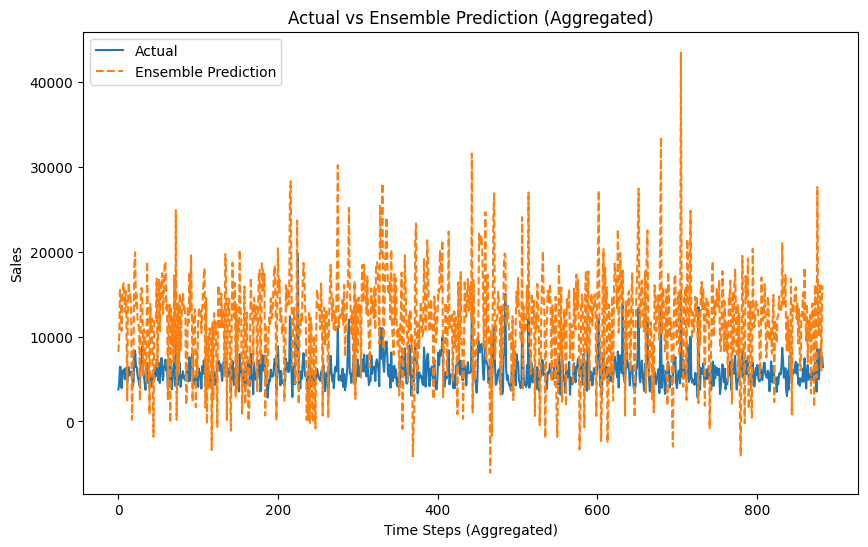

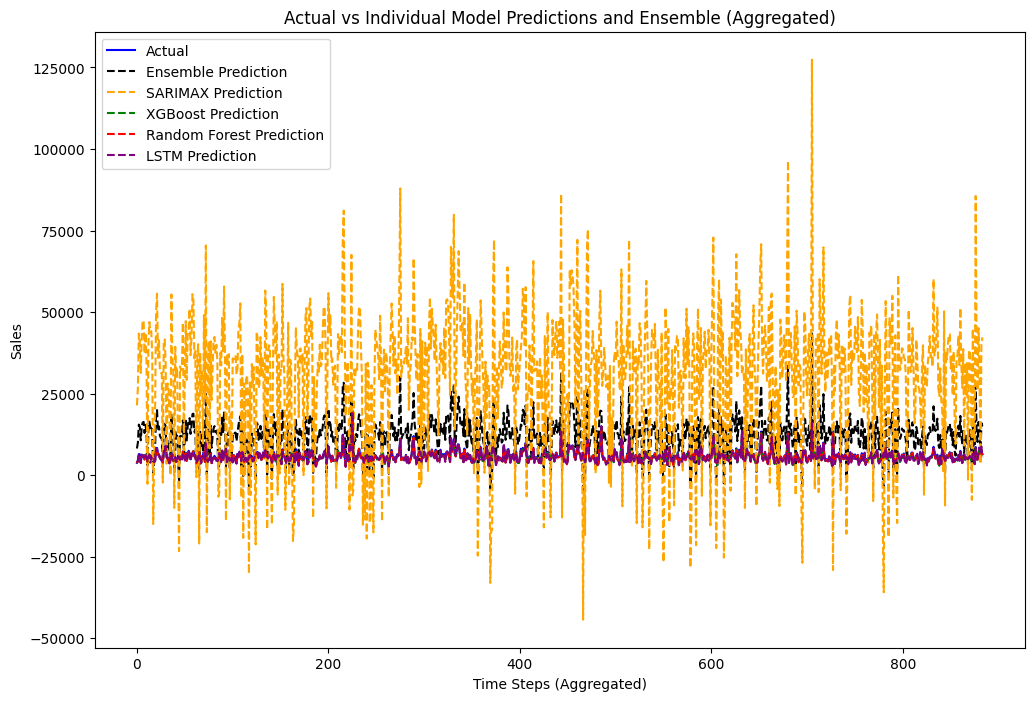

In [25]:
import numpy as np

# Set the aggregation step (e.g., averaging every 100 time steps)
aggregation_step = 200

# Aggregate the actual values and predictions by taking averages
def aggregate_data(data, step):
    return [np.mean(data[i:i+step]) for i in range(0, len(data), step)]

actual_values_agg = aggregate_data(actual_values, aggregation_step)
ensemble_predictions_agg = aggregate_data(ensemble_predictions, aggregation_step)
sarimax_predictions_agg = aggregate_data(sarimax_predictions, aggregation_step)
xgb_predictions_agg = aggregate_data(xgb_predictions, aggregation_step)
rf_predictions_agg = aggregate_data(rf_predictions, aggregation_step)
lstm_predictions_agg = aggregate_data(lstm_predictions, aggregation_step)

# Plot actual vs ensemble prediction (aggregated)
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_values_agg)), actual_values_agg, label='Actual')
plt.plot(range(len(ensemble_predictions_agg)), ensemble_predictions_agg, label='Ensemble Prediction', linestyle='--')
plt.legend()
plt.title('Actual vs Ensemble Prediction (Aggregated)')
plt.xlabel('Time Steps (Aggregated)')
plt.ylabel('Sales')
plt.show()

# Plot individual model predictions vs actual and ensemble (aggregated)
plt.figure(figsize=(12, 8))
x_axis_agg = range(len(actual_values_agg))
plt.plot(x_axis_agg, actual_values_agg, label='Actual', color='blue')
plt.plot(x_axis_agg, ensemble_predictions_agg, label='Ensemble Prediction', linestyle='--', color='black')
plt.plot(x_axis_agg, sarimax_predictions_agg, label='SARIMAX Prediction', linestyle='--', color='orange')
plt.plot(x_axis_agg, xgb_predictions_agg, label='XGBoost Prediction', linestyle='--', color='green')
plt.plot(x_axis_agg, rf_predictions_agg, label='Random Forest Prediction', linestyle='--', color='red')
plt.plot(x_axis_agg, lstm_predictions_agg, label='LSTM Prediction', linestyle='--', color='purple')
plt.legend()
plt.title('Actual vs Individual Model Predictions and Ensemble (Aggregated)')
plt.xlabel('Time Steps (Aggregated)')
plt.ylabel('Sales')
plt.show()
